<a href="https://colab.research.google.com/github/einsteinxx/UCLA_BIOENG_596_FALL_21/blob/main/Read_Ultrasound_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CODE SETUP

'keep_Highscore' function borrowed from Anil Yadav:
 https://github.com/akre96/BUS_tumor_classification/tree/master/segmentation_model/experiments_FasterR-CNN

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc  #debug memory leaks in matplotlib
import csv #read in description files
import random #used to select random slice for patches
import cv2
import re #regexp for BUSI files

!pip3 install -q torchinfo
!pip3 install -Uqq ipdb
################################################################################
#ULTRASOUND NEEDS
import PIL
#from PIL import Image
# Open the image form working directory
#image = Image.open(full_file)
from matplotlib import image
from ast import literal_eval #used to break out bounding boxes from strings
import time
import torch
import torchvision
import torchinfo

from torchinfo import summary
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from numpy import clip

import torchinfo


import ipdb
################################################################################

from google.colab.patches import cv2_imshow
#
# Read Data from google drive
#
from google.colab import drive #for loading gdrive data
from google.colab import files

# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug
!pip3 install -q pickle5

import pydicom #to read dicom files
from pydicom import dcmread
import pickle5 as pickle; #generic storage of image arra

# Load data from google drive
#

drive.mount('/content/gdrive')

data_dir = '/content/gdrive/Shareddrives/BreastUS'
local_dir = '/content/gdrive/My Drive/BreastUS' #for local storage
model_dir = '/content/gdrive/My Drive/BreastUS/MODEL_SAVE'
tensorboard_dir =  '/content/gdrive/My Drive/BreastUS/TENSORBOARD_SUMMARIES'

busi_main_dir = '/content/gdrive/My Drive/BreastUS/BUSI_DATA' #downloaded BUSI


### Enable GPU, if present
train_on_gpu = torch.cuda.is_available()
if (train_on_gpu):
    !nvidia-smi -L
    !nvidia-smi 
    dev=torch.device("cuda")
else:
    print('GPU NOT FOUND!!! USING CPU INSTEAD!!!!!')
    dev=torch.device("cpu")


     |████████████████████████████████| 792 kB 7.9 MB/s 
     |████████████████████████████████| 374 kB 50.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.24 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.31.0 which is incompatible.
     |████████████████████████████████| 2.0 MB 6.9 MB/s 
     |████████████████████████████████| 256 kB 8.6 MB/s 
Mounted at /content/gdrive
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-22a8d109-c1fc-bde1-2b94-feb67d23b296)
Wed Jan 12 05:39:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU 

In [2]:
print(torch.__version__)

1.10.0+cu111


#GET BUSI INFORMATION

In [3]:
use_busi = 1
if (use_busi == 1):
    busi_dirs = os.listdir(busi_main_dir)
    print('busi directories: ', busi_dirs)

    #busi_m_files = os.listdir(os.path.join(busi_main_dir, 'malignant')) #bus_dirs['malignant']))

    m_mask_list = []
    image_m_dict={}
    image_n_dict ={}
    image_b_dict={}

    mask_m_dict = {}
    mask_n_dict ={}
    mask_b_dict = {}

    busi_filename =[]
    busi_category = []
    busi_bbox=[]

    for category in busi_dirs:
        busi_files = os.listdir(os.path.join(busi_main_dir, category))
        
        for filename in busi_files:
            busi_filename.append(filename)
            if ('mask' in filename):
                m_mask_list.append(filename)
                temp= filename.split(' ')
                number = re.findall('\d+',temp[1])
                number = int(number[0])

                full_file = os.path.join(busi_main_dir,category, filename)
                img_data = image.imread(full_file)

                if ('normal' not in category):
                    result =np.where(img_data > 0)
                    rows = min(result[0]),max(result[0])
                    cols = min(result[1]), max(result[1])
                else:
                    #normal cases have a solid 0 mask
                    rows = 0,0
                    cols = 0,0



                #
                # Create Mask coordinates
                #
                #    pos = np.int32(pos)
                #    xmin = pos[0][0]
                #    xmax = pos[1][0]
                #    ymin = pos[0][1]
                #    ymax = pos[2][1]        
                #busi_bbox.append([(rows[0],cols[0]), (rows[0], cols[1]), (rows[1], cols[0]), (rows[1], cols[1])])
                if ('malignant' in temp[0]):
                    mask_m_dict[number]  = [(cols[0],rows[0]), (cols[1],rows[0]), 
                                            (cols[0], rows[1]), (cols[1], rows[1])]
                    #[(rows[0],cols[0]), (rows[0], cols[1]), (rows[1], cols[0]), (rows[1], cols[1])]
                elif ('normal' in temp[0]):
                    mask_n_dict[number] = [] 
                    #[(cols[0],rows[0]), (cols[1],rows[0]), 
                    #                        (cols[0], rows[1]), (cols[1], rows[1])]
                    
                   # [(rows[0],cols[0]), (rows[0], cols[1]), (rows[1], cols[0]), (rows[1], cols[1])]
                elif ('benign' in temp[0]):
                    mask_b_dict[number] = [(cols[0],rows[0]), (cols[1],rows[0]), 
                                            (cols[0], rows[1]), (cols[1], rows[1])]
                   # [(rows[0],cols[0]), (rows[0], cols[1]), (rows[1], cols[0]), (rows[1], cols[1])]
                else:
                    print('Found an incorrect data category')
                    exit()

                
                '''
                plt.figure()
                plt.imshow(img_data,cmap = 'jet')
                plt.colorbar()
                plt.show()
                '''
            else:
                temp= filename.split(' ')
                number = re.findall('\d+',temp[1])
                number = int(number[0])
                full_file = os.path.join(busi_main_dir,category, filename)

                if ('malignant' in temp[0]):
                    image_m_dict[number] = full_file
                elif ('normal' in temp[0]):
                    image_n_dict[number] = full_file
                elif ('benign' in temp[0]):
                    image_b_dict[number] = full_file
                else:
                    print('Found an incorrect data image category')
                    exit()
        print('Done with category: ', category)
                
    print('Done parsing BUSI data')
            

        



busi directories:  ['malignant', 'normal', 'benign']
Done with category:  malignant
Done with category:  normal
Done with category:  benign
Done parsing BUSI data


In [4]:
mask_n_dict[1]

[]

In [5]:
#
# Get DICOM info
#
local_files = os.listdir(local_dir)

for dicom_file in local_files:
    filename = os.path.join(local_dir,dicom_file)
    if (os.path.isdir(filename) == 1):
        #skip any directories found in list
        continue
    if ('dcm' in filename):
        print(filename)
        ds = dcmread(filename, force=True)
        for element in ds:
            print(element)

    else:
        print('Non-dicom file found ',filename)

/content/gdrive/My Drive/BreastUS/1.dcm
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'SMALL PARTS']
(0008, 0012) Instance Creation Date              DA: '20211111'
(0008, 0013) Instance Creation Time              TM: '132938'
(0008, 0016) SOP Class UID                       UI: Ultrasound Multi-frame Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113663.1500.1.365952523.3.2.20210204.132938.671
(0008, 0020) Study Date                          DA: '20211111'
(0008, 0021) Series Date                         DA: '20211111'
(0008, 0023) Content Date                        DA: '20211111'
(0008, 002a) Acquisition DateTime                DT: '20211111'
(0008, 0030) Study Time                          TM: '130201'
(0008, 0031) Series Time                         TM: '130201'
(0008, 0033) Content Time                        TM: '132938'
(0008, 0050) Accession Number       

In [6]:
def get_csv_data(filename):
    fields = []
    rows = []

    # reading csv file
    with open(filename, 'r') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)
        
        # extracting field names through first row
        fields = next(csvreader)

        # extracting each data row one by one
        for row in csvreader:
            rows.append(row)


        # lines present
        print("found rows: %d"%(csvreader.line_num))
    return fields, rows

#Setup Test specific Paths

In [7]:
#Load a dicom image and convert it using dcm_read to get view type (needs this 
#to correctly align image))

csv_dir = os.path.join(data_dir,'Annotated data')

annotated_dir = os.path.join(data_dir,'Annotated data')
data_files = os.listdir(annotated_dir)


label_data_dir = os.path.join(annotated_dir,'LabelMe_3.0_format_updated')
label_files = os.listdir(label_data_dir)



#sample_dicom = os.path.join(dicom_dir,dicom_files[0]) #for now, just use first

#!ls '/content/gdrive/Shareddrives/BreastUS'

# GET CSV INFO

In [8]:
#READ CSV FILES
#pull out the box information and label info
csv_list = os.listdir(csv_dir)

for csv_file in csv_list:
    filename = os.path.join(csv_dir,csv_file)
    if (os.path.isdir(filename) == 1):
        #skip any directories found in list
        continue
    if ('_final' in csv_file):
        annotation_fields, annotation_rows = get_csv_data(filename)

    else:
        print('Non-archive file found ',filename)

found rows: 8843
Non-archive file found  /content/gdrive/Shareddrives/BreastUS/Annotated data/annotations_updated.csv


#Sort CSV DATA INTO FIELDS

In [9]:


print(np.shape(annotation_rows))

print(annotation_fields)

array_rows = np.array(annotation_rows)
mrn = array_rows[:,1]
accession = array_rows[:,2]
video_id = array_rows[:,3]
frame_id = array_rows[:,4]
image_path = array_rows[:,5]
bounding_box = array_rows[:,6]
diagnosis = array_rows[:,7]
biopsy_site = array_rows[:,8]
diagnosis2 = array_rows[:,9]
first50 = array_rows[:,10]


(8842, 11)
['', 'coded_mrn', 'coded_accession', 'video_id', 'frame_id', 'image_path', 'bounding box', 'Final Diagnosis', 'Bx Site', 'Final Diagnosis.1', 'First 50']


In [10]:
type(bounding_box[1000])

numpy.str_

# CROPPING Function

In [11]:
def crop_us_image(img, debug =0):
################################################################################
#
## Look for coordinates to cut the US data out of the image overlay
################################################################################


#
# Get valid rows for the embedded US image
#
    nrows, ncols = np.shape(img)
    middle_column = np.uint(ncols/2)
    middle_row = np.uint(nrows/2)

    #find the 0 gaps before and after the image on the column
    data_strip = img[:,middle_column]
    index = np.where(data_strip == 0) #find first section of 0 values
    first_row_gap = index[0][0]
    diff_row = np.diff(index)


    #find the large jump in diff, that will likely be US image then down to background 0
    #second_row_gap = np.where(diff_row >= 150)
    if (debug == 1):
        print('diff in func ',diff_row)

    leading_found = 0
    trailing_found = 0
    leading_row_edge=0
    for counter,ii in enumerate(diff_row[0]):
        case_status = 1 #assume case will be usable, if not change flag
        if ((counter > 2) and 
            (counter < (np.size(diff_row)-6) )):

            #find a set of diff 0s that skip a distance (edge)
            if ( (diff_row[0][counter-3] <5 ) and
                (diff_row[0][counter-2] <5) and
                (diff_row[0][counter-1] <5) and
                (ii> 10) and
                (leading_found ==0)):
                
                leading_row_edge = index[0][counter]
                leading_found = 1
                
                #print('**found a leading edge at counter, val, image row', counter,ii, leading_row_edge)
                continue
                 #only need first point
            '''
            if ( (diff_row[0][counter+3] ==1 ) and
                (diff_row[0][counter+2] ==1) and
                (diff_row[0][counter+1] ==1) and
                (ii>=2) and 
                (leading_found == 1)):
            '''
            if (leading_found ==1): #(counter > leading_row_edge):

                for jj in range(0,6):
                    if (diff_row[0][counter+jj] <=5):
                        numzero =1
                    else:
                        numzero = 0
                        break
                
                if (numzero == 1):
                    #print('finding trail at ',counter)
                    trailing_row_edge=index[0][counter]
                    trailing_found = 1 #fix this
                    #print('!!found a trail edge at counter, val, image row',
                    #    counter,ii, trailing_row_edge)
                    break
                 #only need first point



    try:
        low_row = leading_row_edge #index[0][second_row_gap[1][0]]
        high_row = trailing_row_edge #index[0][second_row_gap[1][0]+1] 
    except:
        print('could not find a second row for img')
        
        skip_points = [0,0,0,0]
        case_status = 0
        return img, skip_points, case_status #0 signifies this one failed, remove it
    #
    # Clip columns by finding rows with continuous 0 vals. Find the diff between 
    # elements and take the first point where the black transitions to a non-zero 
    # value. This is the first cutoff. The second is where the transition from 
    # regular data to zeros occurs
    #
    data_rows = img[(np.uint(nrows*0.25), np.uint(nrows*0.5), np.uint(nrows*0.75)),:]
    
    if (debug == 1):
        plt.figure()
        x=np.arange(0,ncols)
        plt.plot(x,data_rows[0,:],'r.-',x,data_rows[1,:], 'b.-',x,data_rows[2,:],'k.-')
        

    #top 75% row should be clear of all burned images at the beginning
    xx = np.ediff1d(data_rows[2,:])
    start= np.where(xx >00)

    
    if (not start): #empty list is FALSE
        case_status = 0
        skip_points = [0,0,0,0]
        print('Could not find enough column points, skipping')
        return img, skip_points, case_status #0 signifies this one failed, remove it

    try:
        start_column = start[0][0] +1 #since it's a diff, add one pixel
        final_column = start[0][-1] -1 #last point where diff >0
    except:
        print('Failed to get a "where" point. Skipping')
        case_status = 0
        skip_points = [0,0,0,0]
        return img, skip_points, case_status #0 signifies this one failed, remove it

    '''
    print(start[0])
    plt.figure()
    plt.imshow(img[low_row:high_row,start_column:final_column],cmap='gray')
    plt.title('cropped')
    '''

    #print('inside cropping, shape is ', np.shape(img))
    skip_points = [low_row, high_row,start_column, final_column]
    return img[low_row:high_row,start_column:final_column], skip_points, case_status

##Simple Crop Function

In [12]:
def extract_edge(binary_image,npoint, center,roworcol):
    #
    # Get valid columns/rows from image
    # roworcol = 0 is row, 1 = column

    
    point = [0,npoint]
    edges =[]
    
    for ii in point:
        max_line = 0
        max_default = 1e6
        #print(' ii, center = ', ii, center)
        if (center > ii):
            step = -1
            heading = 0
        else:
            step = 1
            heading = npoint


        for line in range(center,heading,step):
            #nr,nc = np.shape(binary_image)
            #print('bin image = ', binary_image)
            if (roworcol == 0):
                max_vals = np.sum(binary_image[line,:])
            else:
                max_vals = np.sum(binary_image[:,line])
            #print(line, max_vals, roworcol)
            if (max_vals < max_default):
                max_default= max_vals
                max_line = line
            if (max_vals < 250):
                #this is likely outside the core subimage
                break
        #print('max default = ',max_default)
        #print('max line = ',max_line)
        edges.append(max_line)

    status = 1
    if (len(edges) <2):
        edges = [0,0]
        status = 0

    return edges, status

In [13]:
if(0):
    num_mrn = set(mrn)
    num_mrn
    image_path[0:3]

    print(image_path[0])
    filename = os.path.basename(image_path[0]) 
    [_,fpath] =image_path[0].split('drive/MyDrive/Annotated data/')
    full_file = os.path.join(annotated_dir,fpath)
    print(full_file)

    print('filename exists: ',os.path.exists(full_file))
    import imageio

    #import PIL
    #from PIL import Image
    # Open the image form working directory
    #image = Image.open(full_file)

    #from matplotlib import image
    #from matplotlib import pyplot
    img = image.imread(full_file)



    ## Convert the RGB input into grayscale
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B

    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(imgGray, cmap='gray')
    plt.show()

    cropped_image,skip_points,case_status = crop_us_image(imgGray,0)
    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(cropped_image, cmap='gray')
    plt.title('cropped image')


In [14]:
if(0):
    #del cropped_image,  img_data
    img_data = image.imread(idata)
    ## Convert the RGB input into grayscale
    R, G, B = img_data[:,:,0], img_data[:,:,1], img_data[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
    print('shape of imgGray is ', np.shape(imgGray))
    cropped_image, _ = crop_us_image(imgGray,0)
    if (np.size(cropped_image) <1):
        print('Failure during cropping for ', file_name)
    print('shape is ', np.shape(cropped_image))
    plt.figure()
    plt.imshow(cropped_image)

    cropped_image = cv2.resize(cropped_image, dsize=(480, 600),
                                interpolation=cv2.INTER_CUBIC)

### SAVE IMAGES TO DISK

In [15]:
if(0):
    #['', 'coded_mrn', 'coded_accession', 'video_id', 'frame_id', 'image_path', 'bounding box', 'Final Diagnosis', 'Bx Site', 'Final Diagnosis.1', 'First 50']
    '''
    mrn = array_rows[:,1]
    accession = array_rows[:,2]
    video_id = array_rows[:,3]
    frame_id = array_rows[:,4]
    image_path = array_rows[:,5]
    bounding_box = array_rows[:,6]
    diagnosis = array_rows[:,7]
    biopsy_site = array_rows[:,8]
    diagnosis2 = array_rows[:,9]
    first50 = array_rows[:,10]
    '''

    mrn_list = set(mrn)

    acc =set()
    vid = set()

    #try first US video in first mrn


    for count,mm in enumerate(mrn):
        
        if mm in mrn[0]:
            acc.add(accession[count])
            vid.add(video_id[count])

    screen_dir = '/content/gdrive/My Drive/BreastUS/SCREEN_CAPS/'
    #video_save = os.path.join()


    file_name =[]
    vname=[]
    boundary_box = []
    for cc,video_temp in enumerate(video_id):
        [_,fpath] =image_path[cc].split('drive/MyDrive/Annotated data/')
        full_file = os.path.join(annotated_dir,fpath)
        file_name.append(full_file)
        vname.append(video_temp)
        boundary_box.append(bounding_box[cc])

    print(file_name[0])
    print(vname[0])
    print(len(file_name))


    case_holder = []
    failed_list = [] #record of images that failed cropping

    skip_to = 8002 #-1
    for count,ii in enumerate(file_name):

        if (count < skip_to):
            continue #skip these until we get back to the proper file

        #
        # Save folder information. Get the video name and make a folder with that 
        # long name in the screen caps folder
        #
        video_save = os.path.join(screen_dir,vname[count])
        if(os.path.exists(video_save)):
            print('folder found')
        else:
            os.mkdir(video_save)

        img_data = image.imread(ii)
        #print(np.shape(img_data))
        #print('Processing: ', ii)
        print(count)


        corners=literal_eval(boundary_box[count]) #bounding_box[count])
        #bounding box values are in (x,y) formats from xml
        #print('corners, len = ',corners, len(corners))
        #print('bounding box = ',boundary_box[count]) #bounding_box[count])

        '''
        Bounding box ordering is 
        point 1        point 2
        ----------------------
        point 4        point 3
        '''
        if (len(corners)>0):
            #print('corners ',pos)
            pos = np.uint(corners)
            xmin = pos[0][0]
            xmax = pos[1][0]
            ymin = pos[0][1]
            ymax = pos[2][1]
            #boxes.append([xmin, ymin, xmax, ymax])
            h=ymax-ymin
            w=xmax-xmin
        else:
            #print('EMPTY bounding box')
            xmin=np.uint(1)
            xmax=np.uint(2)
            ymin=np.uint(1)
            ymax=np.uint(2)
            h=0
            w=0
            #boxes.append([xmin, ymin, xmax, ymax])



        #skip points =[low_row, high_row,start_column, final_column]
        ## Convert the RGB input into grayscale
        R, G, B = img_data[:,:,0], img_data[:,:,1], img_data[:,:,2]
        imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B


        #
        # Crop the image to the Ultrasound borders. If it fails during this 
        # process, mark it and continue to next image. That failed index will be
        # stored to remove any failed images later
        #
        cropped_image, skip_points,fail_flag = crop_us_image(imgGray,0)


        show_plots = 0
        if (fail_flag == 1): #if cropping worked, process annotations

            #print('skip points = ',skip_points)
            #print('h = ymax-ymin',ymax,ymin,h)
            offset_row = ymin-skip_points[0]
            offset_col = xmin-skip_points[2]

            if (len(corners)>0):
                width = xmax-xmin
                height = ymax-ymin
                rect = patches.Rectangle((offset_col,offset_row),width,height,linewidth=1,edgecolor='r',facecolor='none')
                #print('adding rectangle ',offset_row, offset_col, height, width)
                #print(ymin, ymax, xmin, xmax)
            else:
                rect = patches.Rectangle((0,0),0,0,linewidth=1,edgecolor='r',facecolor='none')

            if (show_plots == 1):
                show_crop = 0
                if (show_crop == 0):

                    fig = plt.figure(figsize=(8, 6), dpi=80)
                    #plt.figure(figsize=(8, 6), dpi=80)
                    #plt.imshow(cropped_image, cmap='gray')
                    plt.imshow(cropped_image,cmap='gray')
                    # Get the current reference
                    ax = plt.gca()
                    # Add the patch to the Axes
                    ax.add_patch(rect)

                    fname = os.path.join(video_save,os.path.basename(ii))
                    #fname = os.path.basename(ii)
                    title_text = 'Frame ' + str(fname)
                    plt.title(title_text)
                    
                    plt.savefig(os.path.join(screen_dir,str(fname)))
                    #time.sleep(1)
                    #plt.show()
                    plt.close()


                if (show_crop == 1):  
                    if (len(corners)>0):
                        plt.figure(figsize=(8, 6), dpi=80)
                        plt.imshow(img_data,cmap='gray')
                
                    # Get the current reference
                        
                        rect = patches.Rectangle((corners[0][0],corners[0][1]),w,h,linewidth=1,edgecolor='r',facecolor='none')
                        bx = plt.gca()
                        # Add the patch to the Axes
                        bx.add_patch(rect)
                        plt.show()
                        plt.close()

        else:
            print('Failed crop for : ',file_name)
            failed_list.append(count)
        #save the fail list and file name list to remove fails later
        if (count%1000 == 0):
            status_file = os.path.join(local_dir,'us_status_index2nd.pickle')

            pickle.dump([failed_list],open( status_file, "wb" ),protocol=5 )


    print('finished plotting all images')


    status_file = os.path.join(local_dir,'us_status_index2nd.pickle')
    pickle.dump([failed_list],open( status_file, "wb" ),protocol=5 )

        



    #print('filename exists: ',os.path.exists(full_file))

    #image = image.imread(full_file)
    #print(np.shape(image))


In [16]:
if(0):
    status_file = os.path.join(local_dir,'Copy of us_status_index.pickle')
    f1 = pickle.load( open( status_file, "rb" ) )

    print(len(f1[0]))



    status_file = os.path.join(local_dir,'us_status_index2nd.pickle')
    f2 = pickle.load( open( status_file, "rb" ) )

    print(len(f2[0]))

    bad_count = f1[0]+f2[0]
    print(len(bad_count))

    bad_files = os.path.join(local_dir,'counters_to_remove.pickle')
    pickle.dump([bad_count],open( bad_files, "wb" ),protocol=5 )

In [17]:
if(0):
    #Test out problem images
    #idata = '/content/gdrive/Shareddrives/BreastUS/Annotated data/unzipped_updated/1_srh8gfhj_a_0629s3fh_0.mp4-2021_07_15_17_21_15-labelme 3.0.zip/default/frame_000036.PNG'
    idata = file_name[8002]
    img_data = image.imread(idata)
    print(np.shape(img_data))

    %pdb off


    ## Convert the RGB input into grayscale
    R, G, B = img_data[:,:,0], img_data[:,:,1], img_data[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B

    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(imgGray,cmap='gray')

    cropped_image, skip_points,fail_flag = crop_us_image(imgGray,1)

In [18]:
if(0):
    idata = '/content/gdrive/Shareddrives/BreastUS/Annotated data/unzipped_updated/1_2w948u10_a_06g91d42_4.mp4-2021_08_20_17_24_25-labelme 3.0.zip/default/frame_000159.PNG'
    idata = '/content/gdrive/Shareddrives/BreastUS/Annotated data/unzipped_updated/1_srh8gfhj_a_0629s3fh_0.mp4-2021_07_15_17_21_15-labelme 3.0.zip/default/frame_000036.PNG'

    img_data = image.imread(idata)
    print(np.shape(img_data))


    ## Convert the RGB input into grayscale
    R, G, B = img_data[:,:,0], img_data[:,:,1], img_data[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B

    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(imgGray,cmap='gray')




    nrows, ncols = np.shape(imgGray)
    middle_column = np.uint(ncols/2)
    middle_row = np.uint(nrows/2)

    #find the 0 gaps before and after the image on the column
    data_strip = imgGray[:,middle_column]
    index = np.where(data_strip == 0) #find first section of 0 values
    print('shape of index= ',np.shape(index))
    print('shape of data strip = ',np.shape(data_strip))
    print('data_strip 0:20 ',data_strip[0:20])
    print('index 0:20 ', index[0][:])


    plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(data_strip)
    plt.ylabel('intensity')
    plt.xlabel('rows')
    ttext = 'Strip Slice at column ' +  str(middle_column)
    plt.title(ttext)

    plt.figure()
    plt.plot(data_strip[400:500])
    plt.title('zoomed')



    first_row_gap = index[0][0]
    diff_row = np.diff(index[0])

    print('diff ' , diff_row)

    for counter,ii in enumerate(diff_row):
        if (counter > 2):
            #find a set of diff 0s that skip a distance (edge)
            if ( (diff_row[counter-3] <5 ) and
                (diff_row[counter-2] <5) and
                (diff_row[counter-1] <5) and
                (ii> 50)):
                print('found an edge at ', counter,ii, index[0][counter])
                second_row_gap = index[0][counter]
                break #only need first point

    #find the large jump in diff, that will likely be US image then down to background 0
    #second_row_gap = np.where(diff_row >= 150)





    print('Second Row Gap ',second_row_gap)
    plt.figure()
    plt.plot(data_strip,'r.-')



    cropped_image, skip_points = crop_us_image(imgGray,1)
    plt.figure()
    plt.imshow(cropped_image,cmap='gray')


In [19]:
### test code
if(0):
    '''
    DOES NOT WORK!!!!!!!!!!!!!!!!!!!!!!!!!!!
    '''
    import cv2
    from google.colab.patches import cv2_imshow
    idata = '/content/gdrive/Shareddrives/BreastUS/Annotated data/unzipped_updated/1_2w948u10_a_06g91d42_4.mp4-2021_08_20_17_24_25-labelme 3.0.zip/default/frame_000159.PNG'

    import cv2

    # Load the image
    img = cv2.imread(idata)

    # convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    edged = cv2.Canny(img, 170, 490)
    # Apply adaptive threshold
    thresh = cv2.adaptiveThreshold(edged, 1, 1, 1, 11, 2)
    thresh_color = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

    # apply some dilation and erosion to join the gaps - change iteration to detect more or less area's
    thresh = cv2.dilate(thresh,None,iterations = 15)
    thresh = cv2.erode(thresh,None,iterations = 15)

    # Find the contours
    contours,hierarchy = cv2.findContours(thresh,
                                            cv2.RETR_TREE,
                                            cv2.CHAIN_APPROX_SIMPLE)

    # For each contour, find the bounding rectangle and draw it
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        cv2.rectangle(img,
                        (x,y),(x+w,y+h),
                        (0,255,0),
                        2)

    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [20]:
if(0):
    #
    # Test images as 3d volumes
    #
    for counter, ii in enumerate(file_name):
        img_data = image.imread(ii)
        print(np.shape(img_data))
        if (counter >0):
            break



        ## Convert the RGB input into grayscale
        R, G, B = img_data[:,:,0], img_data[:,:,1], img_data[:,:,2]
        imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
        cropped_image = crop_us_image(imgGray)
        



        #img = cv2.imread('your_image.jpg')
        cropped_image = cv2.resize(cropped_image, dsize=(600, 480), interpolation=cv2.INTER_CUBIC)

        nr,nc = np.shape(cropped_image)
        img_volume = np.zeros((3,480,600)) #nr,nc))
        img_volume[0,:,:] = cropped_image
        img_volume[1,:,:] = cropped_image
        img_volume[2,:,:] = cropped_image
        
        
        plt.figure(figsize=(8, 6), dpi=80)
        plt.imshow(img_volume[0,:,:], cmap='gray')


In [21]:
def get_bb_stats(bounding_box):
    total_area=[]
    num_box=0
    num_h=[]
    num_w=[]
    for index in range(0,len(bounding_box)):

        #corners=literal_eval(bounding_box[index])

        boxes = []
        area = 0
        #print(type(bounding_box[index]))
        pos=literal_eval(bounding_box[index])

        #print(index,pos)
        #pos = np.double(pos)
        if (len(pos) !=0): #(pos):
            #print('corners ',pos)
            pos = np.int32(pos)
            xmin = pos[0][1]
            xmax = pos[2][1]
            ymin = pos[0][0]
            ymax = pos[1][0]
            w=xmax-xmin
            h = ymax-ymin
            num_h.append(h)
            num_w.append(w)
            boxes.append([xmin, ymin, xmax, ymax])
            area += (xmax-xmin)*(ymax-ymin)
            total_area.append(area)
            num_box+=1
    return total_area, num_box,num_h, num_w

#GET COORDINATES FROM CSV

In [22]:
def get_coordinates(video_id,video_series):
#video_series is the video_id for a series of PNG images taken from a movie.
#Anything with this id will be a frame set that should be kept together

#uvids = set(video_id)

    bbox = []
    for count,v in enumerate(video_id): #video_series:
        if (v in video_series):
            box_info = bounding_box[count]
            #box_info = box_info.strip('][') #.split(', ')

            if (not (box_info =='[]')):
                
                corners=literal_eval(box_info)
                bbox.append(torch.FloatTensor(corners))
                print(corners)
            else:
                bbox.append(torch.FloatTensor(0))

    return bbox


In [23]:
video_id[0]
boxes = get_coordinates(video_id,video_id[0])

[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 1

In [24]:
if (0):  #test out limits for images
    

    for count,file_name in enumerate(full_file_list):

        img_data = image.imread(file_name)



        ## Convert the RGB input into grayscale
        R, G, B = img_data[:,:,0], img_data[:,:,1], img_data[:,:,2]
        imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B

        
        cropped_image, skip_points,ff = crop_us_image(imgGray,0)
        nr,nc = np.shape(cropped_image)
        if ( (nr <10) or (nc <10)):
            print('failed cropping')
            continue
        maxvals = np.max(cropped_image)
        minvals = np.min(cropped_image)
        stdvals = np.std(cropped_image)
        if ((maxvals >1.0 ) or (minvals <0)):
            print('max, min = ', maxvals, minvals,stdvals)



        cropped_image = np.array(cropped_image)



#                         **** Data Loaders ****





---



In [25]:
class CustomDataset(torch.utils.data.Dataset):

    

    def __init__(self,
                 img_dir,
                 label_data,
                 bounding_boxes,
                 category=[],
                 file_count=1,
                 file_list =[],
                 transform=None,
                 target_transform=None):
        #self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.bounding_boxes = bounding_boxes
        self.category = category
        self.file_count = file_count
        self.file_list = file_list
        self.transform = transform
        self.target_transform = target_transform
        self.category_name =''
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.imgs = file_list


    def __getitem__(self, index):

        eps = 2e-16 #keep div by 0 away

        dbprint = 0
        image_dir = self.img_dir
        bounding_boxes = self.bounding_boxes
        file_name = self.file_list[index]

        if(dbprint == 1):
            print('-------------------------  image id: ',index)


        img_data = image.imread(file_name)
        if (dbprint == 1):
            print('image shape read in is ',np.shape(img_data))

        fail_crop = 0 #toggle if cropping fails to alert that this img is bad

        ## Convert the RGB input into grayscale
        R, G, B = img_data[:,:,0], img_data[:,:,1], img_data[:,:,2]
        imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B

        use_crop_style = 1 #try simpler cropping
        if ('BUSI_DATA' in filename):
            #BUSI data does normally not require a crop and this crop function
            #will not work without the embedded image and borders. Skip cropping
            #for all BUSI files
            use_crop_style = 99
        
        if (use_crop_style == 0):
            cropped_image, skip_points,ff = crop_us_image(imgGray,0)
            if (np.size(cropped_image) <1):
                print('!!!!!!!!!!!!!!!!!!!Failure during crop. 400x600 set for ', file_name)
                #we should exit out, but put a fake image for now
                cropped_image = np.zeros((400,600))
                #print('!!!!!!!!!!!!!!!!!!! 400x600 ZERO IMAGE PASSED IN')
                fail_crop = 1 #use this to change label to 0 and iscrowd =1
        elif (use_crop_style == 1):
        # SIMPLE CROPPING #####################################################
        ##skip_points = [low_row, high_row,start_column, final_column]
            binary_image = (imgGray>0).astype(int)
            nr,nc = np.shape(binary_image)
            cen_row = np.uint(nr/2)
            cen_col = np.uint(nc/2)

            column_edges, cstatus= extract_edge(binary_image, nc, cen_col,roworcol=1)
            row_edges, rstatus =  extract_edge(binary_image, nr,cen_row,roworcol=0)

            if ((cstatus == 0) or (rstatus == 0)):
                print('-----failed crop')
                fail_crop =1
            skip_points = [row_edges[0]-1, row_edges[1]+1, column_edges[0]-1, column_edges[1]+1]
            cropped_image = imgGray[row_edges[0]:row_edges[1], column_edges[0]:column_edges[1]]
            
            if (np.size(cropped_image) <1):
                print('!!!!!!!!!!!!!!!!!!!Failure during crop. 400x600 set for ', file_name)
                #we should exit out, but put a fake image for now
                cropped_image = np.zeros((400,600))
        ########################################################################
        elif (use_crop_style == 99):
            #skip any cropping, such as for BUSI data
            cropped_image = imgGray
            skip_points = [0,0,0,0]

        if (dbprint == 1):
            print('about to resize image. shape going in is @index',
                  np.shape(imgGray),np.shape(cropped_image), index)
        
        cropped_image = np.array(cropped_image)

        if (dbprint == 1):
            print('image after crop is ', np.shape(cropped_image))
        #if(type(image) == type(None)):
        #    pass
        #else:
        #    image = cv2.resize(image, (w,h), interpolation=cv2.INTER_AREA)

        oldr,oldc = np.shape(cropped_image) #image shape before resize
        cropped_image = cv2.resize(cropped_image,
                                   dsize=(800,600), #(480,600)
                                   interpolation=cv2.INTER_CUBIC)

        #
        # Normalize image to 0,1
        #
        minvals = np.min(cropped_image)
        maxvals = np.max(cropped_image)
        stdvals = np.std(cropped_image)
        if maxvals > 1:
            cropped_image = (cropped_image - cropped_image.min()) / (cropped_image.max() - cropped_image.min() + eps)
        cropped_image = (cropped_image - cropped_image.mean()) / (cropped_image.std() + eps)
        cropped_image = clip(cropped_image, -1.0, 1.0)
        cropped_image = (cropped_image + 1.0) / 2.0








        #
        # Scaling values for adjusting annotation box coordinates
        # - since the images are likely upsized, the annotations need to be scaled
        # by an amount to correspond to the new image size
        #
        nr,nc = np.shape(cropped_image) #this is the new resized image
        box_scalex = nc/oldc
        box_scaley = nr/oldr


        
        if (dbprint == 1):
            print('resized shapes are ',nr,nc)
            print('scale factors x,y = ',box_scalex,box_scaley)
        '''
        img = np.zeros((3,600,480), dtype=torch.DoubleTensor) #nr,nc))
        img[0,:,:] = cropped_image.astype(torch.DoubleTensor)
        img[1,:,:] = cropped_image.astype(torch.DoubleTensor)
        img[2,:,:] = cropped_image.astype(torch.DoubleTensor)
        '''

        noise = np.random.normal(0.5, .1, cropped_image.shape)
        noisey_cropped_image = cropped_image + noise
        noisey_cropped_image = np.clip(noisey_cropped_image,0.0,1.0)
        noise = np.random.normal(0.5, .01, cropped_image.shape)
        noisey_cropped_image2 = cropped_image + noise
        noisey_cropped_image2 = np.clip(noisey_cropped_image2,0.0,1.0)

        img = np.zeros((3,600,800), dtype=np.double)  #600,480), dtype=np.double) #nr,nc))

        img[0,:,:] = noisey_cropped_image#.astype(np.double)
        img[1,:,:] = cropped_image#.astype(np.double)
        img[2,:,:] = noisey_cropped_image2#.astype(np.double)
        img=img.astype(np.double)
            
        #
                #bbox = torch.FloatTensor(corners)

        # get bounding box coordinates for each mask
        num_objs = len(self.file_list) #bounding_box)
        boxes = []
        #area = 0
        pos=literal_eval(bounding_boxes[index])


        #if (len(corners)>0):
        #    width = xmax-xmin
        #    height = ymax-ymin
        #    rect = patches.Rectangle((offset_col,offset_row),width,height,linewidth=1,edgecolor='r',facecolor='none')
        #skip_points = [low_row, high_row,start_column, final_column]

        if (dbprint == 1):
            corners=literal_eval(bounding_boxes[index])
            print('corners ',pos)

        #pos = np.double(pos)
        if (len(pos) !=0): #(pos):

            pos = np.int32(pos)
            xmin = pos[0][0]
            xmax = pos[1][0]
            ymin = pos[0][1]
            ymax = pos[2][1]
            ### Correct for the cropped image as annotation points are for the 
            ### main image with subset
            offset_row = ymin-skip_points[0]
            offset_col = xmin-skip_points[2]
            max_row = ymax - skip_points[0]
            max_col = xmax - skip_points[2]

            #boxes.append([offset_col, offset_row, 
            #              xmax-skip_points[2], 
            #              ymax-skip_points[0]])
            x0 = offset_col * box_scalex
            y0 = offset_row * box_scaley
            x1 = max_col * box_scalex
            y1 = max_row * box_scaley

            w = x1-x0
            h = y1-y0
            if ((w <10) or (h <10)):
                print('!!!!!! Unusable h/w found: ',h,w)
                print(x0,y0,w,h)
                print('box scale x,y ',box_scalex, box_scaley)
                print('xmin,ymin,xmax,ymax ',xmin,ymin,xmax,ymax)
                print('index is ',index)
                print('skip points ',skip_points)
                print('offset col, row =',offset_col, offset_row)
            boxes.append([x0,y0,x1,y1])
            #boxes.append([offset_col*box_scalex,
            #              offset_row*box_scaley,
            #              (xmax-skip_points[2])*box_scalex,
            #              (ymax-skip_points[0])*box_scaley])
            if (dbprint == 1):
                print('boxes= ',boxes)

            if (dbprint == 1):
                print('offsets are (col,row) ',offset_col, offset_row)
                print('skip points are ', skip_points)
                print('xmax,min,ymax,min = ', xmax,xmin, ymax,ymin)
            #boxes.append([xmin, ymin, xmax, ymax])
            #area = (xmax-skip_points[0] - offset_col) * (ymax-skip_points[2] - offset_row) 
            #adjust area to include new scaled box sizes
            area = ((xmax-skip_points[0] - offset_col)*box_scalex) * ((ymax-skip_points[2] - offset_row) * box_scaley)
            #area += (xmax-xmin)*(ymax-ymin)#!! alter this


        # Handle empty bounding boxes
        if (len(pos) ==0): #num_objs == 0:
            #boxes.append([0,0,0,0])
            #boxes.append([0,0,5,5]) #testing out something with an area
            #boxes = torch.zeros((1, 4), dtype=torch.double)
            #try using the whole image as negative
            nz,nr,nc = np.shape(img)
            #print('--- ',nz,nr,nc)


            boxes = torch.zeros((0, 4), dtype=torch.float32)
            #trying empty boxes instead of full size images
            #boxes.append([0.0,0.0,0.0,0.0])

            #### works: boxes.append([0.0,0.0,nc,nr])
            area = nr*nc
            boxes = torch.as_tensor(boxes, dtype=torch.double)
            #print('empty box size is ',np.shape(boxes))
            #boxes = torch.zeros((0, 4), dtype=torch.double)
            #area = 0 #10*10
            area = torch.as_tensor(area, dtype=torch.double)

            #label = torch.as_tensor(0, dtype=torch.int64) #put as background if no boxes
            label = torch.zeros((1,), dtype=torch.int64)

            iscrowd=torch.ones((1,), dtype=torch.int64)

        else:
            boxes = torch.as_tensor(boxes, dtype=torch.double) 
            #print('filled box size is ',np.shape(boxes))
            area = torch.as_tensor(area, dtype=torch.double)
        
            #label = torch.as_tensor(1, dtype=torch.int64)
            label = torch.ones((1,), dtype=torch.int64)

            iscrowd=torch.zeros((1,), dtype=torch.int64)


        #
        # Protect against zero images from earlier in this function.
        #
        if (fail_crop == 1):
            #force this image to be a background image for training
            print('forcing image as background for failed image')
            label = torch.zeros((1,), dtype=torch.int64)
            iscrowd=torch.ones((1,), dtype=torch.int64)

        if (dbprint == 1):
            print('shape of boxes is ', np.shape(boxes))


        # there is only one class
        #labels = torch.ones((num_objs,), dtype=torch.int64)
        #masks = torch.as_tensor(masks, dtype=torch.uint8)

        #image_id = torch.tensor([idx])
        #area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        ###iscrowd = torch.zeros((len(self.imgs),), dtype=torch.double)

        if (dbprint == 1):
            print('setting target')
            print('label is ', label, type(label))
            print('area is ', area)
        


        target = []
        d = {}
        d['boxes'] = boxes  #np.squeeze(boxes,0)
        d['labels'] = label
        d['image_id'] = torch.as_tensor(index, dtype=torch.double) 
        d['area'] = area 
        d['iscrowd'] = iscrowd 
        target.append(d)

        #self.transform(self.x_data[index]), self.transform(self.y_data[index])
        #return {'image': torch.from_numpy(image),
#                'landmarks': torch.from_numpy(landmarks)}
        #return self.transform(img), self.transform(target)
        
        #print('image type before is ', type(img))
        img = torch.as_tensor(img, dtype=torch.float32) #model has float32 
        #img= torch.from_numpy(img)
        #print('image type after is ', type(img))
        #img = torchvision.transforms.ToTensor()(image)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [26]:
def collate_fn(batch):  #borrowed
    return tuple(zip(*batch))

#GENERATE ALL FILE PATHS 

In [27]:

full_file_list=[]

for file_path in image_path:
    #print(file_path)

    filename = os.path.basename(file_path) 
    [_,fpath] =file_path.split('drive/MyDrive/Annotated data/')
    full_file = os.path.join(annotated_dir,fpath)
    full_file_list.append(full_file)
print('Number of US files: ', len(full_file_list))
original_file_length = len(full_file_list)

bounding_box = list(bounding_box)
first50 = list(first50)
if (use_busi == 1):
    for category in busi_dirs:
        if ('malignant' in category):
            for key_val in image_m_dict.keys():
                full_file_list.append(image_m_dict[key_val])
                bounding_box.append(np.str(mask_m_dict[key_val]))
                first50.append(np.str('M'))

            print('done with adding malignant files')
        elif ('normal' in category):
            for key_val in image_n_dict.keys():
                full_file_list.append(image_n_dict[key_val])
                bounding_box.append(np.str(mask_n_dict[key_val]))
                first50.append(np.str('B'))

            print('done with adding normal files')
        else:
            for key_val in image_b_dict.keys():
                full_file_list.append(image_b_dict[key_val])
                bounding_box.append(np.str(mask_b_dict[key_val]))
                first50.append(np.str('B'))

            print('done with adding benign files')

Number of US files:  8842
done with adding malignant files
done with adding normal files
done with adding benign files


In [28]:
print(bounding_box[1000])
print(bounding_box[9000])


[(385, 201), (544, 201), (544, 309), (385, 309)]
[(32, 52), (177, 52), (32, 237), (177, 237)]


# Bounding Box information

In [29]:
if (0):
    #------not needed??
    # Bounding box info
    #

    import torch
    print('-------')
    uvids = set(video_id)

    for v in uvids:
        for count,ii in enumerate(video_id):
            if (v in ii):
                #get bb info
                box_info = bounding_box[count]
                #box_info = box_info.strip('][') #.split(', ')

                if (not (box_info =='[]')):
                    
                    corners=literal_eval(box_info)
                    bbox = torch.FloatTensor(corners)
                    #print(corners)
                else:
                    continue
    '''
    print(full_file_list[0])
    if (use_busi == 1):
        print('Adding BUSI bounding boxes')
        for filename in full_file_list:
            if ('BUSI_DATA' in filename):
                print(filename)
                #found one of our busi sets, check what category
                #TODO  replace if set with scanf utility to get category
                if ('malignant' in filename):
                    print(filename)
                    first50.append('M')
                    bounding_box.append(mask_m_dict[])
                    break
    '''


#BOUNDING BOX STATISTICS

In [30]:
#generate stats on bounding boxes
uvids = set(video_id)

box_collect=[]
frames_collect=[]
empty_annotations=[]
for count, v in enumerate(uvids):
    number_frames = 0
    number_boxes = 0
    
    #print('---- loading: ', v)
    for icount,ii in enumerate(video_id):
        if (ii == v):
            box_info = bounding_box[icount]
            number_frames+=1
            if (not (box_info =='[]')):
                number_boxes+=1
            else:
                pass
                #print('no annotation', frame_id[icount])
    frames_collect.append(number_frames)
    box_collect.append(number_boxes)
    #print(v,number_frames,number_boxes)
    if (number_boxes == 0):
        empty_annotations.append(v)




print('Number of videos: ',np.size(frames_collect[:]))
print('Number of annotated cases ',np.size(box_collect))
print('Videos with no Annotations:', empty_annotations)
    #get_bb_stats(v, video_id,bounding_box, image_path)


Number of videos:  102
Number of annotated cases  102
Videos with no Annotations: ['1_jq3lf35n_a_12h3r1u8_2.mp4-2021_07_15_17_21_26-labelme 3.0.zip', '1_srh8gfhj_a_0629s3fh_0.mp4-2021_07_15_17_21_15-labelme 3.0.zip', '1_srh8gfhj_a_0629s3fh_3.mp4-2021_07_15_17_21_17-labelme 3.0.zip', '1_2w948u10_a_06g91d42_0.mp4-2021_07_15_17_21_18-labelme 3.0.zip', '1_jq3lf35n_a_12h3r1u8_1.mp4-2021_07_15_17_21_37-labelme 3.0.zip', '1_en9w0q3l_a_e128787p_2.mp4-2021_09_22_21_42_11-labelme 3.0.zip', '1_2w948u10_a_06g91d42_5.mp4-2021_07_15_17_21_37-labelme 3.0.zip', '1_jq3lf35n_a_12h3r1u8_4.mp4-2021_07_15_17_21_22-labelme 3.0.zip', '1_jq3lf35n_a_12h3r1u8_0.mp4-2021_07_15_17_21_32-labelme 3.0.zip', '1_jq3lf35n_a_12h3r1u8_5.mp4-2021_07_15_17_21_17-labelme 3.0.zip', '1_2w948u10_a_06g91d42_2.mp4-2021_07_15_17_21_25-labelme 3.0.zip']


55539.42462073325
168.11931099873578
smallest width is  23
largest width is   467
270.4576485461441
smallest height is  36
largest height is   727
----- [ 76.  88.  38.  95.  52. 201. 439. 291. 426. 396. 139. 518. 264. 190.
 191.  63.  52. 226. 230. 134. 285.  15. 121.  10.  97. 264. 161. 176.
  60.  89.  54. 130.  87. 108. 183.   5. 154. 135.  76.   2.   1.   2.
   0.   0.   0.   1.   2.   0.   0.   1.]
max Height bin is  0 439.0
max Height bin is  1 518.0
max Height bin is  2 285.0
max Height bin is  3 183.0
max Height bin is  4 2.0
----- [ 22.  21.  33. 165.  92. 253. 172. 340. 255. 325. 391. 280. 197. 421.
 629. 407. 103.  21. 214. 154.  10. 434. 172.  97. 155.   6.  11.  11.
   7.  10.   6. 200. 254.  93.  84.   3. 181.  81.   1.   4.   3.   2.
   0.   2.   2.   2.   0.   1.   0.   1.]
max Width bin is  0 340.0
max Width bin is  1 629.0
max Width bin is  2 434.0
max Width bin is  3 254.0
max Width bin is  4 3.0


(array([ 22.,  21.,  33., 165.,  92., 253., 172., 340., 255., 325., 391.,
        280., 197., 421., 629., 407., 103.,  21., 214., 154.,  10., 434.,
        172.,  97., 155.,   6.,  11.,  11.,   7.,  10.,   6., 200., 254.,
         93.,  84.,   3., 181.,  81.,   1.,   4.,   3.,   2.,   0.,   2.,
          2.,   2.,   0.,   1.,   0.,   1.]),
 array([ 23.  ,  31.88,  40.76,  49.64,  58.52,  67.4 ,  76.28,  85.16,
         94.04, 102.92, 111.8 , 120.68, 129.56, 138.44, 147.32, 156.2 ,
        165.08, 173.96, 182.84, 191.72, 200.6 , 209.48, 218.36, 227.24,
        236.12, 245.  , 253.88, 262.76, 271.64, 280.52, 289.4 , 298.28,
        307.16, 316.04, 324.92, 333.8 , 342.68, 351.56, 360.44, 369.32,
        378.2 , 387.08, 395.96, 404.84, 413.72, 422.6 , 431.48, 440.36,
        449.24, 458.12, 467.  ]),
 <a list of 50 Patch objects>)

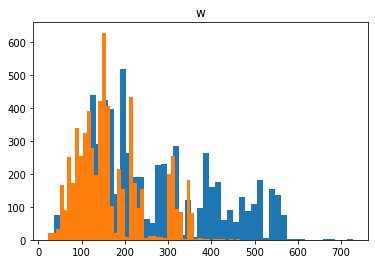

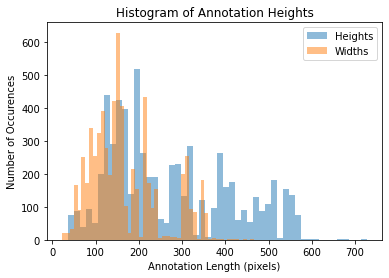

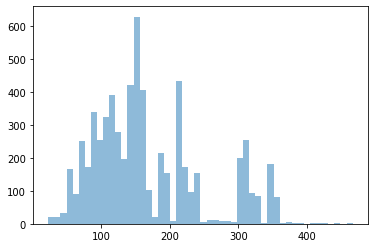

In [31]:
#bounding_box
ta,box_num,num_h, num_w=get_bb_stats(bounding_box)

avg_area = sum(ta)/len(ta)
print(avg_area)

#avg width
print(np.average(num_w))
#get smallest box

print('smallest width is ', np.min(num_w))
print('largest width is  ', np.max(num_w))

#avg height
print(np.average(num_h))
print('smallest height is ', np.min(num_h))
print('largest height is  ',np.max(num_h))

vv,_,_=plt.hist(num_h, bins = 50)
plt.title('h')
print('-----',vv)

for ii in range(0,5):
    bin_max = np.max(vv[ii*10:ii*10+9])
    print('max Height bin is ', ii,bin_max)

vv,_,_=plt.hist(num_w, bins = 50)
plt.title('w')
print('-----',vv)

for ii in range(0,5):
    bin_max = np.max(vv[ii*10:ii*10+9])
    print('max Width bin is ', ii,bin_max)




plt.figure()
plt.hist(num_h, bins=50,alpha=0.5, label="Heights")
plt.hist(num_w,bins=50,alpha=0.5, label="Widths")
plt.title('Histogram of Annotation Heights')
plt.ylabel('Number of Occurences')
plt.xlabel('Annotation Length (pixels)')
plt.legend(loc='upper right')

plt.figure()
plt.hist(num_w,bins=50,alpha=0.5, label="Widths")


In [32]:
np.str(bounding_box[9000])

'[(32, 52), (177, 52), (32, 237), (177, 237)]'

#SPLIT INTO TRAIN/VAL/TEST FOLDERS

In [33]:
#break into a training and validation set
'''
array_rows = np.array(annotation_rows)
mrn = array_rows[:,1]
accession = array_rows[:,2]
video_id = array_rows[:,3]
frame_id = array_rows[:,4]
image_path = array_rows[:,5]
bounding_box = array_rows[:,6]
diagnosis = array_rows[:,7]
biopsy_site = array_rows[:,8]
diagnosis2 = array_rows[:,9]
first50 = array_rows[:,10]
'''
types_acc = np.unique(accession)
num_acc = len(types_acc)
print('number of unique accs is ', num_acc, len(accession))

unique_vidid = np.unique(video_id)

train_pct = 0.8
val_pct = 0.1
test_pct = 1-train_pct-val_pct


cancer_status ={}
for vname in unique_vidid:
    for pcount, pathname in enumerate(image_path):
        if (vname in pathname):
            cancer_status[vname] = first50[pcount]
            break

print(cancer_status)
print(cancer_status.values())

vid_vals = list(cancer_status.keys())
cvals = list(cancer_status.values())
print(cvals)
print(vid_vals)


#Remove the bad counters 
bad_files = os.path.join(local_dir,'counters_to_remove.pickle')
bad_count = pickle.load( open( bad_files, "rb" ) )
print(len(bad_count[0]))

bad_vidid = np.unique(video_id[bad_count[0]])
print('bad video ids: ', bad_vidid)


good_list=[]

for counter,ii in enumerate(image_path):
    skip_me = 0
    for jj in bad_vidid:
        if(jj in video_id[counter]):
            print('bad video id found: ',ii)
            skip_me=1
            break

    if (skip_me == 1):
        good_list.append(counter)


print(len(bad_vidid))
print('len of image path is ', len(image_path), len(bad_vidid), len(bad_count[0]))
print('len good list: ',len(good_list))

print(image_path[good_list[0]])
print('bad count = ', bad_count[0][80:90])
print(image_path[bad_count[0][500]])


number of unique accs is  44 8842
{'1_076up782_a_dcc4675o_0.mp4-2021_09_03_16_33_59-labelme 3.0.zip': 'B', '1_076up782_a_dcc4675o_1.mp4-2021_09_03_16_36_25-labelme 3.0.zip': 'B', '1_0zw0m57r_a_6v90rk5f_0.mp4-2021_08_24_23_23_01-labelme 3.0.zip': 'M', '1_0zw0m57r_a_6v90rk5f_1.mp4-2021_08_24_23_27_07-labelme 3.0.zip': 'M', '1_1y57j09v_a_1clh6ogf_1.mp4-2021_09_26_17_36_15-labelme 3.0.zip': 'M2', '1_25s1kz8d_a_a7a2a5ah_0.mp4-2021_08_11_19_24_29-labelme 3.0.zip': 'B', '1_25s1kz8d_a_a7a2a5ah_1.mp4-2021_08_11_19_27_06-labelme 3.0.zip': 'B', '1_2i3g7i29_a_578479c8_0.mp4-2021_09_03_17_42_08-labelme 3.0.zip': 'M', '1_2v209811_a_yr4xdm24_0.mp4-2021_09_07_04_41_13-labelme 3.0.zip': 'B', '1_2v209811_a_yr4xdm24_1.mp4-2021_09_07_04_39_27-labelme 3.0.zip': 'B', '1_2w948u10_a_06g91d42_0.mp4-2021_07_15_17_21_18-labelme 3.0.zip': 'M', '1_2w948u10_a_06g91d42_1.mp4-2021_08_10_01_00_43-labelme 3.0.zip': 'M', '1_2w948u10_a_06g91d42_2.mp4-2021_07_15_17_21_25-labelme 3.0.zip': 'M', '1_2w948u10_a_06g91d42_3.mp4

#Test out cropping on bad images

In [34]:
#
# Test all of the bad crops against new crop functions
#

if(0):
    #Remove the bad counters 
    bad_files = os.path.join(local_dir,'counters_to_remove.pickle')
    bad_count = pickle.load( open( bad_files, "rb" ) )
    print(len(bad_count[0]))

    number_failed = []
    for ii in bad_count[0]:
        filename = full_file_list[ii]
        print('now on file ',ii)
        #print(filename)

        img_data = image.imread(filename)
        ## Convert the RGB input into grayscale
        R, G, B = img_data[:,:,0], img_data[:,:,1], img_data[:,:,2]
        imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B


        #crop_img, skipped, status= crop_us_image(imgGray,debug =1)
        binary_image=(imgGray>0).astype(int)
        #print('shape in ',np.shape(binary_image))
        #print('sum is ', np.sum(binary_image[:,0]))
        nr,nc = np.shape(binary_image)
        cen_row = np.uint(nr/2)
        cen_col = np.uint(nc/2)
        #print('cenc col ', cen_col)
        #print('cen row ', cen_row)
        #plt.figure()
        #plt.imshow(binary_image, cmap='gray')
        colum_edges, cstatus= extract_edge(binary_image, nc, cen_col,roworcol=1)
        row_edges, rstatus =  extract_edge(binary_image, nr,cen_row,roworcol=0)

        if ((cstatus == 0) or (rstatus == 0)):
            print('-----failed crop')
            number_failed.append(ii)


        '''
        #plt.figure()
        #plt.imshow(binary_image[row_edges[0]:row_edges[1],column_edges[0]:column_edges[1]],cmap='gray')
        break
        '''
    bad_remaining = os.path.join(local_dir,'remaining_bad_counters_to_remove.pickle')
    pickle.dump(number_failed,open( bad_remaining, "wb" ))


#REMOVE PRE-DETERMINED LIST OF UNCROPPABLE IMAGES

In [35]:
#skipped due to a better cropping setup
if (0):
    #Remove the bad counters 
    bad_files = os.path.join(local_dir,'counters_to_remove.pickle')
    bad_count = pickle.load( open( bad_files, "rb" ) )
    print(len(bad_count[0]))

    new_flist =[]
    new_bb = []
    new_first50=[]
    for counter, fname in enumerate(full_file_list):
        if counter in bad_count[0]:
            print('found bad counter ',counter)
        else:
            new_flist.append(fname)
            new_bb.append(bounding_box[counter])
            new_first50.append(first50[counter])

    full_file_list = new_flist
    bounding_box = new_bb
    first50=new_first50
else:
    print('All Data Sets added to lists')


All Data Sets added to lists


#ASSIGN TRAINING/VALIDATION/TEST FILES

In [36]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader

def train_val_dataset(dataset, val_split=0.20):
    train_idx, val_idx = train_test_split(list(range(len(dataset))),
                                          test_size=val_split)
    #datasets = {}
    #datasets['train'] = Subset(dataset, train_idx)
    #datasets['val'] = Subset(dataset, val_idx)
    return train_idx, val_idx #datasets

#Split BUSI Data into Train/Val sets

In [37]:
#Split the BUSI data files, as they're not related sets

t,v = train_val_dataset(full_file_list[8842:], val_split=0.2)
for counter, ii in enumerate(t):
    t[counter] = ii+original_file_length
for counter, ii in enumerate(v):
    v[counter] = ii + original_file_length

print(len(full_file_list))
print(np.max(t), np.max(v))
for ii in t:
    print(full_file_list[ii])


9622
9621 9615
/content/gdrive/My Drive/BreastUS/BUSI_DATA/benign/benign (225).png
/content/gdrive/My Drive/BreastUS/BUSI_DATA/malignant/malignant (39).png
/content/gdrive/My Drive/BreastUS/BUSI_DATA/benign/benign (242).png
/content/gdrive/My Drive/BreastUS/BUSI_DATA/benign/benign (430).png
/content/gdrive/My Drive/BreastUS/BUSI_DATA/benign/benign (30).png
/content/gdrive/My Drive/BreastUS/BUSI_DATA/benign/benign (414).png
/content/gdrive/My Drive/BreastUS/BUSI_DATA/benign/benign (198).png
/content/gdrive/My Drive/BreastUS/BUSI_DATA/benign/benign (309).png
/content/gdrive/My Drive/BreastUS/BUSI_DATA/normal/normal (30).png
/content/gdrive/My Drive/BreastUS/BUSI_DATA/malignant/malignant (147).png
/content/gdrive/My Drive/BreastUS/BUSI_DATA/malignant/malignant (58).png
/content/gdrive/My Drive/BreastUS/BUSI_DATA/benign/benign (15).png
/content/gdrive/My Drive/BreastUS/BUSI_DATA/normal/normal (116).png
/content/gdrive/My Drive/BreastUS/BUSI_DATA/normal/normal (44).png
/content/gdrive/My Dr

In [38]:
num_train = np.uint16(np.floor(train_pct*len(unique_vidid)))
num_val = np.floor(val_pct*len(unique_vidid))
num_test = np.uint16(np.floor(test_pct*len(unique_vidid)))

train_list = []
val_list = []
test_list = []
train_labels=[]
val_labels =[]
test_labels = []
train_box =[]
val_box=[]
test_box = []

train_vidid=[]
val_vidid = []
test_vidid = []

print('num unique vid id ',len(unique_vidid))
train_length = train_pct * len(unique_vidid)
val_length = val_pct * len(unique_vidid)
test_length = test_pct * len(unique_vidid)

for counter, vname in enumerate(unique_vidid):
    if (counter <= train_length): #train_pct*len(unique_vidid)): #*100):
        train_vidid.append(vname)
    elif ((counter > train_length) and (counter <= (train_length +val_length))):
        val_vidid.append(vname)
    else:
        test_vidid.append(vname)

for counter, filename in enumerate(full_file_list):

    for vname in train_vidid:
        if(vname in filename):
            train_list.append(filename)
            train_labels.append(first50[counter])
            train_box.append(bounding_box[counter])
            break
                
    for vname in val_vidid:
        if(vname in filename):   
            val_list.append(filename)
            val_labels.append(first50[counter])
            val_box.append(bounding_box[counter])
            break

    for vname in test_vidid:
        if(vname in filename):   
            test_list.append(filename)
            test_labels.append(first50[counter])
            test_box.append(bounding_box[counter])
            break                

#Add BUSI data to the end of the lists
if (use_busi ==1):
    for counter, ii in enumerate(t):
        train_list.append(full_file_list[ii])
        train_labels.append(first50[ii])
        train_box.append(bounding_box[ii])
    for counter, ii in enumerate(v):
        val_list.append(full_file_list[ii])
        val_labels.append(first50[ii])
        val_box.append(bounding_box[ii])

'''
train_list = []
val_list = []
train_labels=[]
val_labels =[]
train_box =[]
val_box=[]


for counter,dir_name in enumerate(train_vidid):
    print(dir_name)
    for ii in os.path.join()
    train_list.append(fname)
'''

#print the files used for later stages and their labes and boxes
data_file = os.path.join(model_dir,'train_val_test_data.pickle')
pickle.dump([train_list, train_labels,
             train_box,
             val_list,
             val_labels,
             val_box, 
             test_list,
             test_labels,
             test_box],open( data_file, "wb" ),protocol=5 )
print('Finished writing file data to disk')

print('--- ',len(train_list), len(val_list), len(test_list),num_train, num_val,num_test)



num unique vid id  102
Finished writing file data to disk
---  7853 843 926 81 10.0 10


In [39]:

train_box[7700]
ii= 5303
print(train_list[ii])
img = image.imread(train_list[ii])
print('--- ', len(train_box[ii]))
pos=literal_eval(train_box[ii])

print('pos length = ',len(pos))
if (len(pos) <1 ):
    print('no annotation to view')
else:
    pos = np.int32(pos)
    xmin = pos[0][0]
    xmax = pos[1][0]
    ymin = pos[0][1]
    ymax = pos[2][1]

    target_boxes = pos #train_box[ii]
    plt.figure()
    plt.imshow(img[:,:,0],cmap='gray')


    print(target_boxes)
    ax = plt.gca()
    rect2 = patches.Rectangle((np.uint(xmin),
                            np.uint(ymin)),
                            np.uint(xmax)-(np.uint(xmin)),
                            np.uint(ymax)-(np.uint(ymin)),
                            linewidth=1.2,edgecolor='k',facecolor='none')


        # Add the patch to the Axes

    if (len(target_boxes)==0):
        legend_text = ['Prediction']
    else:
        ax.add_patch(rect2)
        legend_text = ['Prediction', 'Annotation']
    plt.legend(legend_text)
    plt.colorbar()

/content/gdrive/Shareddrives/BreastUS/Annotated data/unzipped_updated/1_fmw39oaf_a_n4p8955p_0.mp4-2021_09_03_17_22_23-labelme 3.0.zip/default/frame_000045.PNG
---  2
pos length =  0
no annotation to view


#SET UP TRAINING DATA 

In [40]:
#load up with the pre-sized patch images
from torchvision import transforms, utils

'''
training_data = CustomDataset(img_dir=annotated_dir,
                                label_data = first50,
                                category = '', #full_category_name, 
                                file_count=len(full_file_list), #full_file_count,
                                file_list = full_file_list, 
                                transform=None, 
                                target_transform=None)
'''

training_data = CustomDataset(img_dir=annotated_dir,
                                bounding_boxes = train_box,
                                label_data = train_labels,
                                category = '', #full_category_name, 
                                file_count=len(train_list), #full_file_count,
                                file_list = train_list, 
                                transform=None, 
                                target_transform=None)



validation_data = CustomDataset(img_dir=annotated_dir,
                                bounding_boxes = val_box,
                                label_data = val_labels,
                                category = '', #full_category_name, 
                                file_count=len(val_list), #full_file_count,
                                file_list = val_list,
                                transform=None, 
                                target_transform=None)


test_data = CustomDataset(img_dir=annotated_dir,
                                bounding_boxes = test_box,
                                label_data = test_labels,
                                category = '', #full_category_name, 
                                file_count=len(test_list), #full_file_count,
                                file_list = test_list,
                                transform=None, 
                                target_transform=None)



#Save Train/Val/Test data sets for reuse

In [41]:
#Save the generated data for use in restarting epochs to avoid mixing training
#data with val or test data

if(1):
    stored_data =[training_data, validation_data, test_data, bounding_box,
                first50]
    last_data_file = os.path.join(model_dir,'last_data_set.pickle')
    pickle.dump([stored_data],open( last_data_file, "wb" ),protocol=5 )
    print('****** STORED GENERATED DATA SETS *******')

In [42]:
def bb_intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = abs(max(0, xB - xA + 1) * max(0, yB - yA + 1))
    if interArea == 0:
        return 0.0
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

#Keep_HighScore Function

In [101]:
def keep_Highscore(output):
    processed_dict = []
    processed_dict_scores=[]
    processed_dict_labels=[] #for use in the metrics
    for i in range(len(output)):
        out = output[i]['boxes'].cpu().numpy().squeeze()
        scores = output[i]['scores'].cpu().numpy().squeeze()
        labels = output[i]['labels'].cpu().numpy().squeeze()
        if len(out.shape) > 1:
            if len(out) == 0:
                processed_dict.append({'boxes': []})
                processed_dict_scores.append({'scores': []})
                processed_dict_labels.append({'labels': []})
            else:
                #keep the maximum score
                processed_dict_scores.append({'scores': scores[np.argmax(scores)]})
                processed_dict.append({'boxes': out[np.argmax(scores)]})
                processed_dict_labels.append({'labels': labels[np.argmax(scores)]})
        elif (len(out.shape) == 1):
            processed_dict.append({'boxes': out})
            processed_dict_scores.append({'scores': scores}) #out[np.argmax(scores)]})

            processed_dict_labels.append({'labels': labels}) #labels[np.argmax(scores)]})
        else:
            print('Found a non-matched highest output size ', len(out.shape))
            print('keep high --scores ',scores)
            print('labels, argmax', labels,np.argmax(scores))
            print('shape = ', len(out.shape) ,np.shape(out),np.shape(scores),np.shape(labels))
            print('** ',labels[0])
           
            print('-----> ', labels[np.argmax(scores)])
    return processed_dict, processed_dict_scores, processed_dict_labels

#IOU Calculation

In [44]:
def IOU(box1, box2):

    db_print = 0
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2
    x_inter1 = max(x1, x3)
    y_inter1 = max(y1, y3)
    x_inter2 = min(x2, x4)
    y_inter2 = min(y2, y4)
 
    if (db_print ==1):
        print('IOU calc:----')
        print(box1)
        print(box2)
        print(x_inter1, y_inter1, x_inter2, y_inter2)

    width_inter = abs(x_inter2 - x_inter1)
    height_inter = abs(y_inter2 - y_inter1)
    area_inter = width_inter * height_inter
    width_box1 = abs(x2 - x1)
    height_box1 = abs(y2 - y1)
    width_box2 = abs(x4 - x3)
    height_box2 = abs(y4 - y3)
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    area_union = area_box1 + area_box2 - area_inter

    if (db_print == 1):
        print('IOU calc2:----')
        print('area box 1, box2, area union:')
        print(area_box1, area_box2, area_union)
        print('area inter = ', area_inter)

    iou = area_inter / area_union


    ''' 
    We assume that the box follows the format:
    box1 = [x1,y1,x2,y2], and box2 = [x3,y3,x4,y4],
    where (x1,y1) and (x3,y3) represent the top left coordinate,
    and (x2,y2) and (x4,y4) represent the bottom right coordinate 
    '''
    return iou

In [45]:
'''
if (train_on_gpu == 1):
    m = nn.LogSoftmax(dim=1).cuda(dev)
    nll_loss = nn.NLLLoss().cuda(dev)
else:
    m = nn.LogSoftmax(dim=1)
    nll_loss = nn.NLLLoss()

L1loss = nn.L1Loss()
'''

'\nif (train_on_gpu == 1):\n    m = nn.LogSoftmax(dim=1).cuda(dev)\n    nll_loss = nn.NLLLoss().cuda(dev)\nelse:\n    m = nn.LogSoftmax(dim=1)\n    nll_loss = nn.NLLLoss()\n\nL1loss = nn.L1Loss()\n'

In [46]:

#normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                 std=[0.229, 0.224, 0.225])

#summary(modelr)
#del modelr
#summary(modelr)


# Model Import/Design

In [47]:
#tensorboard for debugging views
use_tensorboard = 1
if (use_tensorboard == 1):
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter(tensorboard_dir)

#RESNET50 PRE-TRAINED  w/ CUSTOM ANCHOR

In [ ]:
torch.cuda.empty_cache()

eps = 2e-16 #keep div by 0 away

model_dir = '/content/gdrive/My Drive/BreastUS/MODEL_SAVE'


#anchor_generator = AnchorGenerator(sizes=((64, 128,256, 512, 600),),
#                                   aspect_ratios=((0.5, 0.75, 1.0),))

#Set Anchor sizes and aspect
anchor_sizes = ((64,), (128,), (256,), (512,), (600,)) 
#anchor_sizes = ((16,), (32,), (64,), (128,), (256,)) 
aspect_ratios = ((0.5, 0.75, 1.0),) * len(anchor_sizes) 
anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)

num_classes = 2

modelr=torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, 
                                                            num_classes=2,
                                                            pretrained_backbone=True)
#modelr = torchvision.models.detection.maskrcnn_resnet50_fpn(num_classes=2)
#resnet50_fpn = torchvision.models.detection.maskrcnn_resnet50_fpn(num_classes=2)
'''
backbone_fpn = nn.Sequential(
	resnet50_fpn.backbone.body.conv1,
	resnet50_fpn.backbone.body.bn1,
	resnet50_fpn.backbone.body.relu,
	resnet50_fpn.backbone.body.maxpool,
	resnet50_fpn.backbone.body.layer1,
	resnet50_fpn.backbone.body.layer2,
	resnet50_fpn.backbone.body.layer3,
	resnet50_fpn.backbone.body.layer4
	)
backbone_fpn.out_channels = 2048
modelr = FasterRCNN(backbone_fpn,num_classes=2,rpn_anchor_generator=anchor_generator)
'''

#resnet_net = torchvision.models.resnet50(pretrained=True)

'''
modules = list(resnet_net.children())[:-1]
backbone = nn.Sequential(*modules)
backbone.out_channels = 2048
#backbone = resnet50_fpn('resnet50', pretrained_backbone)
modelr = FasterRCNN(backbone,num_classes=2,rpn_anchor_generator=anchor_generator)
#resnet50_fpn.out_channels=2048
#modelr = FasterRCNN(resnet50_fpn,num_classes=2,rpn_anchor_generator=anchor_generator)
'''
#num_features = modelr.in_features
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# get the number of input features 
in_features = modelr.roi_heads.box_predictor.cls_score.in_features
# define a new head for the detector with required number of classes
modelr.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
modelr.rpn.anchor_generator = anchor_generator   #adding in customized anchors


#freeze all layers
for param in modelr.parameters():
    param.requires_grad = False

#kaggle setup
#unfreeze the classification and box prediction 
for p in modelr.roi_heads.box_predictor.parameters():
    p.requires_grad =True

for p in modelr.rpn.parameters():
    p.requires_grad = True #True

for p in modelr.backbone.fpn.parameters():
    p.requires_grad = False #True

for p in modelr.roi_heads.box_head.parameters():
    p.requires_grad = True

#save parameters requiring a gradient update
params = [p for p in modelr.parameters() if p.requires_grad]
print(summary(modelr))




# freeze the fc6 layer in roi_heads
'''
for p in modelr.roi_heads.box_head.fc6.parameters():
    p.requires_grad = False
'''


'''
#Add a fully connected layer at the end with two outputs for our classes
#modelr.fc = nn.Sequential(
#               nn.Linear(2048, 128),
#               nn.ReLU(inplace=True),
#               nn.Linear(128, 2)).to(dev)


#fc_inputs = modelr.fc.in_features
modelr.fc = nn.Sequential(
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2),
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)
for param in modelr.fc:
    param.requires_grad = True 


for p in modelr.rpn.parameters():
    print(p)
    p.requires_grad = True

print('Model Params with Grad=True')
for n, param in modelr.named_parameters():
  if param.requires_grad==True:
    print(n)
'''


#params = [p for p in self.model.parameters() if p.requires_grad]
#for param in modelr.fc():
#    param.requires_grad==True

#optimizer = optim.Adam(modelr.fc.parameters(), lr=0.01)

#optimizer = torch.optim.Adam(params,lr=1e-3) #, weight_decay=0.0005)

optimizer = torch.optim.SGD(params, lr=1e-5) #,momentum=0.9,weight_decay=0.0005) #, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.SGD(modelr.fc.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
#                                                       mode='min',
#                                                       factor = 0.1,
#                                                       patience=2,
#                                                       verbose=True)

if (train_on_gpu):
    modelr = modelr.to(dev)




# define list to store the smooth loss and learning rate
smooth_loss_list  = []
lr_list = []
batch_num = 0
avg_loss = 0
best_loss = 0


epoch_loss = []
min_intersection =0.0
highest_intersection =0

train_loss_per_epoch=[]
val_loss_per_epoch=[]

start_epoch = 0
num_epochs = 200

#
# Continue previous training from a known state
#
use_last_epoch = 0
if (use_last_epoch == 1):
    saved_dict= os.path.join(model_dir,'fasterrcnn_trained_last')
    modelr.load_state_dict(torch.load(saved_dict))

    archived_data = pickle.load( open( last_data_file, "rb" ) )
    training_data = archived_data[0][0]
    validation_data = archived_data[0][1]
    test_data =archived_data[0][2]
    bounding_box = archived_data[0][3]
    first50 =archived_data[0][4]


    #training_data, validation_data, test_data, bounding_box, first50 = pickle.load( open( last_data_file, "rb" ) )


    optimizer = torch.optim.SGD(params, lr=1e-5) #, momentum=0.9, weight_decay=0.0005)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    start_epoch = 41
    num_epochs = 400


batch_size = 10
data_loader = torch.utils.data.DataLoader(training_data,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=2,
                                          drop_last=True,
                                          collate_fn=collate_fn)


val_data_loader = torch.utils.data.DataLoader(validation_data,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=2,
                                          drop_last=True,
                                          collate_fn=collate_fn)


for epoch in range(start_epoch,num_epochs):
    print('-------------- Epoch ',epoch)
    epoch_loss = []
    train_loss =0
    #with torch.no_grad(): #trying enabled
    with torch.set_grad_enabled(True):
        for i, data in enumerate(data_loader, 0):
            if (i%100 == 0):
                print('----> Batch Training load epoch & training loss ',i,train_loss)
            
            #set model to update weights
            modelr.train() #eval()

            images = data[0]
            targets = data[1]


            imagelist=[]
            for ii in range(0,len(images)):
                #imagelist.append(images[ii])
                if (train_on_gpu):
                    imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32).to(dev))
                else:
                    imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32))

            #print(np.shape(images), len(images))
            #print(np.shape(imagelist[0]))


            #
            # Reformat the target dictionary
            #
            target_new = []
            for ii in range(0,len(images) ): #batch_size):
                d={}

                if (train_on_gpu == 1):
                    d['boxes'] = torch.as_tensor(targets[ii][0]['boxes']).to(dev)
                    d['labels'] = torch.as_tensor(targets[ii][0]['labels']).to(dev)
                    d['image_id'] = torch.as_tensor(targets[ii][0]['image_id']).to(dev)
                    d['area'] = torch.as_tensor(targets[ii][0]['area']).to(dev)
                else:
                    d['boxes'] = targets[ii][0]['boxes']
                    d['labels'] = targets[ii][0]['labels']
                    d['image_id'] = targets[ii][0]['image_id']
                    d['area'] = targets[ii][0]['area']                  
                target_new.append(d)



            #forward pass
            loss_dict = modelr(imagelist, target_new) #targets)
            # zero the parameter gradients
            optimizer.zero_grad()
            
            losses = sum(loss for loss in loss_dict.values())
            
            #print('*** SUMMED losses is ', losses)
            #print(loss_dict)
            train_loss += losses

            if (i%1000== 0):
                print('training loss ', train_loss/i/batch_size)

            # backward pass
            losses.backward()
            # update optimizer
            optimizer.step()

            epoch_loss.append(float(losses.item() * len(imagelist)))
    scheduler.step()
    ###scheduler.step(np.mean(epoch_loss))


    train_loss_per_epoch.append(train_loss)

    # Save the latest set of training losses
    training_loss_file  = os.path.join(model_dir,'training_loss_epoch.pickle')
    pickle.dump([train_loss_per_epoch],open( training_loss_file, "wb" )) #,protocol=5 )


    #
    # Tensorboard write
    #
    if (use_tensorboard == 1):
        writer.add_scalar(' Training Loss per epoch', train_loss, epoch)
        writer.flush() #write out all the info to the board

    ############################################################################
    # VALIDATION STEP
    ############################################################################

    val_epoch_iou = 0.0
    avg_iou_batch_list=[]
    with torch.no_grad():
        modelr.eval()     # Optional when not using Model Specific layer
        
        for vcount, vdata in enumerate(val_data_loader, 0):
            avg_iou_per_batch=0.0
            if (vcount%100 == 0):
                print('----> Batch Validation load #',vcount)
            val_images = vdata[0]
            val_targets = vdata[1]
            #targets = targets.to(dev)
            #np.squeeze(targets[0]['boxes'], 1)

            val_imagelist=[]
            for kk in range(0,len(val_images)):
                #imagelist.append(images[ii])
                if (train_on_gpu):
                    val_imagelist.append(torch.as_tensor(val_images[kk], dtype=torch.float32).to(dev))
                else:
                    val_imagelist.append(torch.as_tensor(val_images[kk], dtype=torch.float32))

            #print(np.shape(val_images), len(val_images))
            #print(np.shape(val_imagelist[0]))

            #
            # Reformat the target dictionary
            #
            target_val = []
            for kk in range(0,batch_size):
                d={}
                #d['boxes'] = targets[0]['boxes'][ii]
                '''
                #MOBILENET ARCH
                if (train_on_gpu == 1):
                    d['boxes'] = torch.as_tensor(val_targets[0]['boxes'][ii]).to(dev)
                    d['labels'] = torch.as_tensor(val_targets[0]['labels'][ii]).to(dev)
                    d['image_id'] = torch.as_tensor(val_targets[0]['image_id'][ii]).to(dev)
                    d['area'] = torch.as_tensor(val_targets[0]['area'][ii]).to(dev)
                else:
                    d['boxes'] = val_targets[0]['boxes'][ii]
                    d['labels'] = val_targets[0]['labels'][ii]
                    d['image_id'] = val_targets[0]['image_id'][ii]
                    d['area'] = val_targets[0]['area'][ii]                  
                target_val.append(d)
                '''

                #RESNET50 ARCH
                if (train_on_gpu == 1):
                    d['boxes'] = torch.as_tensor(val_targets[kk][0]['boxes']).to(dev)
                    d['labels'] = torch.as_tensor(val_targets[kk][0]['labels']).to(dev)
                    d['image_id'] = torch.as_tensor(val_targets[kk][0]['image_id']).to(dev)
                    d['area'] = torch.as_tensor(val_targets[kk][0]['area']).to(dev)
                else:
                    d['boxes'] = val_targets[kk][0]['boxes']
                    d['labels'] = val_targets[kk][0]['labels']
                    d['image_id'] = val_targets[kk][0]['image_id']
                    d['area'] = val_targets[kk][0]['area']                  
                target_val.append(d)

            ############################################################
            #forward pass
            ############################################################
            eval_out = modelr(val_imagelist) #targets)

            #
            #Loss calculation for the best boxes
            #
            annotations = target_val
            output = eval_out

            iou_over_batch = 0.0
            iou=0.0

            #Keep only the box with highest score 
            high_out, box_scores,highest_label = keep_Highscore(output) #From Anil's setup

            valid_count = 0

            # Basic metrics for confusion matrix
            val_TP = 0
            val_FP = 0
            val_TN = 0
            val_FN = 0
            for i in range(len(high_out)): #output)):

                #single values for the predicted box and truth box
                out = high_out[i]['boxes']
                annotation = annotations[i]['boxes'].cpu().numpy().squeeze()
                

                #
                # Calculate IOU and Metrics
                #


                if ((highest_label[i]['labels'] == 0) and 
                    (annotations[i]['labels'].cpu().numpy() ==0)):
                    #This is a TRUE NEGATIVE MATCH
                    val_TN = val_TN + 1
                elif (( highest_label[i]['labels'] == 1) and
                    (annotations[i]['labels'].cpu().numpy() ==0)):
                        val_FP = val_FP + 1
                        iou = 0.0
                elif ((highest_label[i]['labels']  == 1) and
                    (annotations[i]['labels'].cpu().numpy() ==1)):
                    val_TP = val_TP + 1
                    #this should have its IOU calculated 
                    iou = bb_intersection_over_union(annotation, out)
                    iou_over_batch += iou
                    valid_count = valid_count + 1
                elif ((highest_label[i]['labels']  == 0) and
                    (annotations[i]['labels'].cpu().numpy() ==1)):
                    val_FN = val_FN + 1
                    iou = 0.0

                
                #We should only be tracking IOU for cases where a 
                #predicted box appears and/or a truth box is present
                #penalize the wrong predictions


                '''
                if len(out) == 0 or len(annotation) == 0:
                    iou = 0.0
                    #print('empty of 0 len annotation found')
                    if (len(annotation) == 0):
                        #print('Non Annotated Image pushed through eval')
                        pass
                else:
                    iou = bb_intersection_over_union(annotation, out)
                    iou_over_batch += iou
                    valid_count = valid_count + 1
                '''
            
            if (valid_count == 0):
                print('!! No annotated files in batch or all failures')
            avg_iou_per_batch =iou_over_batch/(valid_count + eps) #len(high_out)
            if (vcount%10 == 0):
                print('avg iou/batch = @ batch#',avg_iou_per_batch,vcount, iou_over_batch)
                print('    Metrics (TP,FP,TN,FN)', val_TP, val_FP, val_TN, val_FN)

            avg_iou_batch_list.append(avg_iou_per_batch)
        
        avg_batch_iou = np.sum(avg_iou_batch_list)/ len(avg_iou_batch_list)
        val_epoch_iou =avg_batch_iou #/validation_data

    val_loss_per_epoch.append(val_epoch_iou)

    #save the validation loss values per each epoch
    val_loss_file  = os.path.join(model_dir,'validation_loss_epoch.pickle')
    pickle.dump([val_loss_per_epoch],open( val_loss_file, "wb" )) #,protocol=5 )

    if (val_epoch_iou > highest_intersection):
        print('New high avg iou = ',val_epoch_iou)
        highest_intersection = val_epoch_iou
        print("-" * 20)
        best_model_name = 'BestIOU_' + str(highest_intersection) # str(np.int(best_accuracy*100)) + '_EPOCH_' +str(epoch)+'_' + str(valid_loss)
        torch.save(modelr.state_dict(),os.path.join(model_dir,best_model_name))

    print('Mean Epoch Loss = ', np.mean(epoch_loss))
    print('highest val IOU is: ',highest_intersection)

    #save intermediate dictionary each epoch
    torch.save(modelr.state_dict(),os.path.join(model_dir,'fasterrcnn_trained_last'))

#save the metrics

loss_file = os.path.join(model_dir,'train_val_loss.pickle')
pickle.dump([train_loss_per_epoch, val_loss_per_epoch],open( loss_file, "wb" ),protocol=5 )




    #epoch_loss.append(train_loss/batch_size)
        
################################################################################
# Finalize the tensor file 
if (use_tensorboard == 1):
    writer.close()
################################################################################

Layer (type:depth-idx)                                  Param #
FasterRCNN                                              --
├─GeneralizedRCNNTransform: 1-1                         --
├─BackboneWithFPN: 1-2                                  --
│    └─IntermediateLayerGetter: 2-1                     --
│    │    └─Conv2d: 3-1                                 (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      --
│    │    └─ReLU: 3-3                                   --
│    │    └─MaxPool2d: 3-4                              --
│    │    └─Sequential: 3-5                             (212,992)
│    │    └─Sequential: 3-6                             (1,212,416)
│    │    └─Sequential: 3-7                             (7,077,888)
│    │    └─Sequential: 3-8                             (14,942,208)
│    └─FeaturePyramidNetwork: 2-2                       --
│    │    └─ModuleList: 3-9                             (984,064)
│    │    └─ModuleList: 3-10                            (2,360,

In [108]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.01
    lr: 1.0000000000000003e-18
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [103]:
#annotations[i]['labels'].cpu().numpy()
#output[0]['labels'][3].cpu().numpy().squeeze()
scores = output[0]['scores'].cpu().numpy().squeeze()
print(scores)
#output[0][np.argmax(scores)]
id = np.argmax(scores)
print(id)


high_out, box_scores,highest_label = keep_Highscore(output) 



valid_count = 0

# Basic metrics for confusion matrix
val_TP = 0
val_FP = 0
val_TN = 0
val_FN = 0
for i in range(len(high_out)): #output)):

    #single values for the predicted box and truth box
    out = high_out[i]['boxes']
    annotation = annotations[i]['boxes'].cpu().numpy().squeeze()
    

    #
    # Calculate IOU and Metrics
    #
    if ((highest_label[i]['labels'] == 0) and 
        (annotations[i]['labels'].cpu().numpy() ==0)):
        #This is a TRUE NEGATIVE MATCH
        val_TN = val_TN + 1
    elif (( highest_label[i]['labels'] == 1) and
        (annotations[i]['labels'].cpu().numpy() ==0)):
        val_FP = val_FP + 1
        iou = 0.0
    elif ((highest_label[i]['labels']  == 1) and
        (annotations[i]['labels'].cpu().numpy() ==1)):
        val_TP = val_TP + 1
        #this should have its IOU calculated 
        iou = bb_intersection_over_union(annotation, out)
        iou_over_batch += iou
        valid_count = valid_count + 1
    elif ((highest_label[i]['labels']  == 0) and
        (annotations[i]['labels'].cpu().numpy() ==1)):
        val_FN = val_FN + 1
        iou = 0.0



#output[i]['labels'].cpu().numpy()[0]
#optimizer
#modelr.roi_heads.box_head


#for p in modelr.roi_heads.box_head.parameters():
#    p.requires_grad = True

#├─RoIHeads: 1-4                                         --
#│    └─MultiScaleRoIAlign: 2-5                          --
#│    └─TwoMLPHead: 2-6                                  --
#│    │    └─Linear: 3-15                                (12,846,080)
#│    │    └─Linear: 3-16                                (1,049,600


[0.08826974 0.06241115 0.06005485 0.05643585]
0


In [ ]:
modelr.rpn

#modelr.rpn.anchor_generator = anchor_generator
#rpn_anchor_generator=anchor_generator

anchor_sizes = ((32,), (64,), (128,), (256,), (512,)) 
aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes) 
anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)
                                   

#Load Saved model dictionary for testing

In [ ]:
#final_file = os.path.join(model_dir,'vgg16_best_accuracy_97_gpu')
model_dict=os.path.join(model_dir,'BEST_MODEL','BestIOU_0.44082309005236775')
#'121521_50epoch_Adam','BestIOU_0.43511341297247597_121521') #BestIOU_0.31124280825584255') #BestIOU_0.2270519932219383')
modelr.load_state_dict(torch.load(model_dict))

#training_loss_file  = os.path.join(model_dir,'training_loss_epoch.pickle')




##CAM TESTING

In [ ]:
no_of_layers=0
conv_layers=[]
 
model_children=list(modelr.children())
 

 
for child in model_children:
  if type(child)==nn.Conv2d:
    no_of_layers+=1
    conv_layers.append(child)
  elif type(child)==nn.Sequential:
    for layer in child.children():
      if type(layer)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(layer)
print(no_of_layers)

print(modelr)

In [ ]:
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

In [ ]:
# Visualize feature maps

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:

activation = {}
'''
    (2): Bottleneck(
        (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(512, eps=1e-05)
        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(512, eps=1e-05)
        (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(2048, eps=1e-05)
        (relu): ReLU(inplace=True)
'''
print(modelr.backbone.body.layer4[0])
print(modelr.rpn.head.cls_logits)
print('-----')
#modelr.roi_heads.box_predictor.cls_score
print(modelr.backbone.body.layer4[0].conv1)
#modelr.backbone.body.layer4[2].conv3.register_forward_hook(get_activation('conv2D'))
#modelr.rpn.head.bbox_pred.register_forward_hook(get_activation('conv2D'))
modelr.rpn.head.cls_logits.register_forward_hook(get_activation('conv2D'))
#modelr.roi_heads.box_predictor.cls_score.register_forward_hook(get_activation('Linear'))
#model.conv1.register_forward_hook(get_activation('conv1'))
#modelr.roi_heads.box_predictor.cls_score.register_forward_hook(get_activation('conv2D')) #'Dense'))


batch_size =10
val_data_loader = torch.utils.data.DataLoader(validation_data,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=2,
                                          drop_last=True,
                                          collate_fn=collate_fn)

for vcount, vdata in enumerate(val_data_loader, 0):
    avg_iou_per_batch=0.0
    if (vcount%100 == 0):
        print('----> Batch Validation load #',vcount)
    val_images = vdata[0]
    val_targets = vdata[1]
    #targets = targets.to(dev)
    #np.squeeze(targets[0]['boxes'], 1)

    val_imagelist=[]
    for kk in range(0,len(val_images)):
        #imagelist.append(images[ii])
        if (train_on_gpu):
            val_imagelist.append(torch.as_tensor(val_images[kk], dtype=torch.float32).to(dev))
        else:
            val_imagelist.append(torch.as_tensor(val_images[kk], dtype=torch.float32))
    break

modelr.eval()
print('length of val images ',len(val_imagelist))
eval_out = modelr(val_imagelist)
#print(eval_out)


print('shape of val image is ', np.shape(val_imagelist[0]))
plt.figure()
plt.imshow(val_imagelist[0][0,:,:].to('cpu'), cmap='gray')
plt.colorbar()

print('get activation')
act = activation['conv2D'].squeeze() #conv2D
print('shape act, size(0) ',np.shape(act),act.size(0))
fig, axarr = plt.subplots(1,act.size(0),figsize=(20,20))
for idx in range(0,act.size(0)):
    axarr[idx].imshow(act[idx][0,:,:].to('cpu'),cmap='jet')


print('adding cam elements and heatmap')
cam = act[0].to('cpu')
w= 800
h= 600
cam = cv2.resize(np.float32(cam), (w,h))
print('cam resized')
print(type(cam))
print('max in image is ', np.max(cam))
plt.figure()
plt.imshow(cam[:,:,0],cmap='jet')
plt.colorbar()

cam = (cam - np.min(cam))/np.ptp(cam)
print('max after conversion is ', np.max(cam), np.min(cam))
cam = cam[:,:,0]

heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255

plt.figure()
plt.imshow(heatmap,cmap='jet')
tempimage = val_imagelist[0][0,:,:]
print('shape of heatmap is ', np.shape(heatmap))
cam = heatmap[:,:,0] + np.float32(tempimage.to('cpu'))
cam = cam / np.max(cam)

plt.figure()
plt.imshow(cam,cmap='jet')
plt.colorbar()

In [ ]:
val_targets[0]

In [ ]:
list(modelr.children())
modelr.backbone.body.layer4[0]
model_children=list(modelr.backbone.body.layer4[2].children())


no_of_layers=0
conv_layers=[]
#print(model_children)
for child in model_children:
    print(type(child))

    if (type(child) == nn.Conv2d):
        no_of_layers+=1
        conv_layers.append(child)
    elif type(child)==nn.Sequential:
        for layer in child.children():
            if type(layer)==nn.Conv2d:
                no_of_layers+=1
                conv_layers.append(layer)    
print(no_of_layers)    



temp_image = cv2.resize(val_imagelist[0][0,:,:].cpu().numpy(), (2048,512))

temp_image = temp_image[:,:,None,None]
#t_resized = F.resize(temp_image, 1)


print(np.shape(temp_image))
#idata = torch.rand(512,2048,1,100)
#idata=normalize_output(idata)
#idata = idata.cuda()


temp_image = normalize_output(temp_image)
temp_image = torch.tensor(temp_image).cuda()
results =[]
print('conv[0] ',conv_layers[0])
results = [conv_layers[0](temp_image)]
plt.figure()
plt.imshow(temp_image[:,:,0,0].cpu())


for i in range(1, len(conv_layers)):
    print('----> now on i= ',i,conv_layers[i])
    print(conv_layers[i])
    
    results.append(conv_layers[i](results[-1]))
    outputs = results
outputs = results



layer_viz = outputs[0][1, :, :, :]
layer_viz = layer_viz.data
np.shape(layer_viz.data)
plt.figure()
plt.plot(layer_viz.data[:,0,0].to('cpu'))


In [ ]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print("Layer ",num_layer+1)
    for i, filter in enumerate(layer_viz):
        if i == 16: 
            break
        
        plt.subplot(2, 8, i + 1)
        filter = filter.to('cpu')
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()

In [ ]:
def printnorm(self, input, output):
    # input is a tuple of packed inputs
    # output is a Tensor. output.data is the Tensor we are interested
    print('Inside ' + self.__class__.__name__ + ' forward')
    print('')
    print('input: ', type(input))
    print('input[0]: ', type(input[0]))
    print('output: ', type(output))
    print('')
    print('input size:', input[0].size())
    print('output size:', output.data.size())
    print('output norm:', output.data.norm())

In [ ]:
def get_last_conv_name(net):
    """
    :param net:
    :return:
    """
    layer_name = None
    for name, m in net.named_modules():
        if isinstance(m, nn.Conv2d):
            layer_name = name
    return layer_name

In [ ]:
import argparse
import os
import re

import cv2
import numpy as np
import torch
from skimage import io
from torch import nn
from torchvision import models

!pip install -q timm grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM,EigenCAM, EigenGradCAM, LayerCAM, FullGrad
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image

#from interpretability.grad_cam import GradCAM, GradCamPlusPlus
#from interpretability.guided_back_propagation import GuidedBackPropagation


parser = argparse.ArgumentParser()
parser.add_argument('--network', type=str, default='resnet50',
                    help='ImageNet classification network')
#arguments = parser.parse_args()
layer_name = get_last_conv_name(modelr) #if args.layer_name is None else args.layer_name
print(layer_name)
modelr.rpn.head.bbox_pred.register_forward_hook

grad_cam = GradCAM(modelr, layer_name)
mask = grad_cam(inputs, args.class_id)  # cam mask
image_dict['cam'], image_dict['heatmap'] = gen_cam(img, mask)
grad_cam.remove_handlers()
# Grad-CAM++
grad_cam_plus_plus = GradCamPlusPlus(net, layer_name)
mask_plus_plus = grad_cam_plus_plus(inputs, args.class_id)  # cam mask
image_dict['cam++'], image_dict['heatmap++'] = gen_cam(img, mask_plus_plus)
grad_cam_plus_plus.remove_handlers()



In [ ]:


#net.conv2.register_forward_hook(printnorm)



print(modelr)
modelr.roi_heads.box_predictor
#modelr.register_forward_hook
print('*' * 20)
print(modelr.backbone.body.layer4[2].conv3)
last_cnn = modelr.backbone.body.layer4[2].conv3
modelr.backbone.body.layer4.register_forward_hook(printnorm)
#modelr._modules.get('backbone')   #'cls_logits')
#print('--' * 20)
#print(last_cnn)

print(val_imagelist)
out_data = modelr(val_imagelist)
print(out_data)

In [ ]:
!pip install -q captum


import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(modelr)

print(np.shape(val_imagelist[0]))

layer_gradcam = LayerGradCam(modelr,modelr.backbone.body.layer4[2].conv3)# model.layer3[1].conv2)

idata = torch.zeros((1,3,244,244))
idata = idata.cuda()


images_batch = torch.from_numpy(np.array(val_imagelist[0].cpu()))
attributions_lgc = layer_gradcam.attribute(idata, target=1)
_ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                             sign="all",
                             title="Layer 4 Conv 3")


# Ask the algorithm to attribute our output target to
#attributions_ig = integrated_gradients.attribute(val_imagelist[0], n_steps =1) #, target=pred_label_idx, n_steps=200)


In [ ]:
activated_features = SaveFeatures(last_cnn) 

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM,EigenCAM, EigenGradCAM, LayerCAM, FullGrad
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image

cam=GradCAM(model=modelr,
                    target_layers=modelr.backbone.body.layer4, #[2].conv3, 
                    use_cuda=True)
#cam.batch_size = 32

input_tensor = idata[0].unsqueeze_(0)

#input_tensor = input_tensor.to(dev)
target_category = None
grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)


In [ ]:
class SaveFeatures(): 
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)  # attach the hook to the specified layer
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy() # copy the activation features as an instance variable
    def remove(self): self.hook.remove()

#Produce Training and Validation Loss Plots

In [ ]:
training_loss_file  = os.path.join(model_dir,'121521_50epoch_Adam','training_loss_epoch.pickle')
validation_loss_file  = os.path.join(model_dir,'121521_50epoch_Adam','validation_loss_epoch.pickle')
#tloss = load(training_loss_file)
data = pickle.load( open( training_loss_file, "rb" ) )
vdata = pickle.load( open( validation_loss_file, "rb" ) )
tloss = data[0]
vloss = vdata[0]


test_data_loader = torch.utils.data.DataLoader(test_data,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=2,
                                          drop_last=True,
                                          collate_fn=collate_fn)

print(len(data))
#print(np.array(tloss))
num_files = len(   test_data_loader)
#print(len(train_loss_per_epoch))
#print(len(val_loss_per_epoch))
#print(len(data_loader))
#epoch_loss.append(float(losses.item() * len(imagelist)))
plt.figure()
plt.plot(np.array(tloss)/(num_files - 6),'ro-')
#plt.title('Total Loss Training')

#plt.figure()
plt.plot(np.array(vloss),'b.-') #/len(val_data_loader))
plt.title('Total Loss Training & Validation')
plt.legend(['Training','Validation'])
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss,IOU')
#train_epoch= np.array(train_loss_per_epoch)/1000
#plt.figure()
#plt.plot(val_loss_per_epoch,'b.-')
#plt.plot(train_epoch,'ro-')



In [ ]:
tloss

In [ ]:
eval_out[0]
print(len(validation))
print(len(eval_out))
print(target_new)
#loss_dict
#targets
#modelr.rpn

ifile = full_file_list[5251]
print(ifile)
img_data = image.imread(ifile)
print(np.shape(img_data))
plt.figure()
plt.imshow(img_data[:,:,0],cmap='gray')
cropped_image, skip_points,ff = crop_us_image(img_data[:,:,0],0)
print(skip_points)

In [ ]:
class GradCam:
    def __init__(self, model):
        import torch.nn.functional as F
        self.model = model.eval()
        self.feature = None
        self.gradient = None

    def save_gradient(self, grad):
        self.gradient = grad

    def __call__(self, x):
        image_size = (x.size(0), x.size(1),x.size(2))
        print('image_size = ', image_size)
        feature_maps = []
        
        for i in range(x.size(0)):
            img = x[i].data.cpu().numpy()
            img = img - np.min(img)
            if np.max(img) != 0:
                img = img / np.max(img)

            feature = x[i].unsqueeze(0)
            
            for name, module in self.model.named_children():
                if name == 'classifier':
                    feature = feature.view(feature.size(0), -1)
                feature = module(feature)
                if name == 'features':
                    feature.register_hook(self.save_gradient)
                    self.feature = feature
                    
            classes = F.sigmoid(feature)
            one_hot, _ = classes.max(dim=-1)
            self.model.zero_grad()
            one_hot.backward()

            weight = self.gradient.mean(dim=-1, keepdim=True).mean(dim=-2, keepdim=True)
            
            mask = F.relu((weight * self.feature).sum(dim=1)).squeeze(0)
            mask = cv2.resize(mask.data.cpu().numpy(), image_size)
            mask = mask - np.min(mask)
            
            if np.max(mask) != 0:
                mask = mask / np.max(mask)
                
            feature_map = np.float32(cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET))
            cam = feature_map + np.float32((np.uint8(img.transpose((1, 2, 0)) * 255)))
            cam = cam - np.min(cam)
            
            if np.max(cam) != 0:
                cam = cam / np.max(cam)
                
            feature_maps.append(transforms.ToTensor()(cv2.cvtColor(np.uint8(255 * cam), cv2.COLOR_BGR2RGB)))
            
        feature_maps = torch.stack(feature_maps)
        
        return feature_maps

In [ ]:
#for idata,tdata in val_data_loader:
#    print(tdata)
summary(modelr)
#fmaps=GradCam(modelr)

import numpy as np
from PIL import Image

#image = Image.open("lena.png")
#np_array = np.array(image)

#pil_image=Image.fromarray(np_array)
#pil_image.show()


transform = transforms.Compose([
    transforms.Resize((800, 600)),
    transforms.ToTensor(),
])

random = torch.rand(3,800,600).to(dev)
random = torch.tensor(random).double()
array=random
#array = np.random.randint(255, size=(800, 600),dtype=np.uint8)
image = array #Image.fromarray(array)

#test_image = np.zeros((3,600,800))
#pil_image = Image.fromarray(test_image)
#test_image = Image.open("../images/cavy.jpg")
test_image_tensor = image #(transform((image))) #.unsqueeze(dim=0)


grad_cam = GradCam(modelr)

#test_image_tensor = (transform((test_image))).unsqueeze(dim=0)
#test_image_tensor = torch.tensor(test_image_tensor)

feature_image = grad_cam(test_image_tensor) #.squeeze(dim=0)
feature_image = transforms.ToPILImage()(feature_image)

pred_idx = model(test_image_tensor).max(1)[1]
print("pred: ", labels[int(pred_idx)])
plt.title("Grad-CAM feature image")
plt.imshow(feature_image.resize(image_size))

#GRADCAM TEST

In [ ]:
modelr
#modelr.backbone.body #.layer4[0].conv3

In [ ]:
#print(modelr)

!pip3 install -q medcam
from medcam import medcam


def activation_hook(inst, inp, out):
    """Run activation hook.
    Parameters
    ----------
    inst : torch.nn.Module
        The layer we want to attach the hook to.
    inp : tuple of torch.Tensor
        The input to the `forward` method.
    out : torch.Tensor
        The output of the `forward` method.
    """
    print("Here")
    #writer.add_histogram(repr(inst), out)
#!pip3 install -q pytorch_grad_cam
!pip install -q timm grad-cam
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layer = modelr.backbone.body.layer4[0].conv3 #[-1] #layer4[-1]
#input_tensor = # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
#cam = GradCAM(model=modelr, target_layers=target_layer, use_cuda=True)



# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
model = modelr

model.eval()

# get the softmax weight
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].cpu().data.numpy())

finalconv_name = model.backbone.body.layer4[-1]
model.backbone.body.layer4[-1].register_forward_hook(hook_feature)
logit = model(val_imagelist)
'''
#handle1 = modelr.rpn.register_forward_hook(activation_hook)   #backbone.fpn.register_forward_hook(activation_hook)
#y = modelr(val_imagelist)
map_dir = os.path.join(tensorboard_dir,'MAPS')
model_out = medcam.inject(modelr, output_dir=map_dir, backend='gcam',  label='best', save_maps=True)

print(model_out)
model_out.eval()


for idata,tdata in val_data_loader:

    for ii in range(0,2): #len(tdata)):
        counter =counter+1
        val_imagelist=[]
        if (train_on_gpu):
            val_imagelist.append(torch.as_tensor(idata[ii], dtype=torch.float32).to(dev))
        else:
            val_imagelist.append(torch.as_tensor(idata[ii], dtype=torch.float32))

        output = model_out(val_imagelist)
#for p in modelr.backbone.fpn.parameters():
#    p.requires_grad = False #True

from torch.utils.tensorboard import SummaryWriter
log_dir = os.path.join(tensorboard_dir,'tensorboad_logs') #  pathlib.Path.cwd() / "tensorboard_logs"
writer = SummaryWriter(log_dir)

    handle_1 = net.fc_1.register_forward_hook(activation_hook)
    net.fc_2.register_forward_hook(activation_hook)
    net.fc_3.register_forward_hook(activation_hook)

    y = net(x)
    handle_1.remove()
    y = net(x)
'''

#Calculate Metrics

In [ ]:
def calculate_metrics(labels, y_pred_tags,y_pred_score):
    #calculate PRECISION and other metrics to guage the model results
    #get # of true cancer cases, find # of cancer cases falsely predicted
    from sklearn.metrics import average_precision_score

    temp_labels = []
    temp_prediction = []
    true_pos =[]


    #initialize variables for manual calculations
    TP = 0 #true positive
    FP = 0 #false positive
    TN = 0 #true negative
    FN = 0 #false negative
    BP = 0 #benign positive match
    BN = 0 #benign negative match
    num0=0
    num1=0
    num2=0


    for count,i in enumerate(range(len(labels))): 


        if (np.sum(y_pred_tags[i]) > 1):
            predicted_label = y_pred_tags[i][0]
        elif (y_pred_tags[i].size > 0):
            predicted_label = 1
        else:
            predicted_label = 0

        
        if (np.sum(y_pred_score[i]) > 1):
            label_score = y_pred_score[i][0]
        elif (y_pred_score[i].size > 0):
            label_score = y_pred_score[i]

        

        if predicted_label==labels[i]==1:
            TP += 1

        #FP
        if predicted_label==1 and labels[i]!=predicted_label:
            FP += 1
        #if y_pred_tags[i]==1 and labels[i]!=y_pred_tags[i]:
        #    FP += 1

        #TN
        if labels[i]==predicted_label==0:
            TN += 1
        #if labels[i]==y_pred_tags[i]==1:
        #    TN += 1

        #FN
        if predicted_label==0 and labels[i]==1: #!=y_pred_tags[i]:
            FN += 1
        #if y_pred_tags[i]==1 and labels[i]==2: #!=y_pred_tags[i]:
        #    FN += 1


        if (predicted_label==0):
            num0+=1
        elif (predicted_label == 1):
            num1+=1
        else:
            num2 +=1

    #F1 Score = 2*(Recall * Precision) / (Recall + Precision)
    print('Predicted Matches Pred#0,Pred#1,Pred#2 = ',num0,num1,num2)

    final_accuracy = (TP+TN)/(TP+FP+FN+TN +1e-12)
    print('Accuracy is ',final_accuracy)
    final_precision = TP/(TP+FP + 1e-12)
    print('Precision is ',final_precision)
    final_recall_sens = TP/(TP + FN + 1e-12)
    print('Recall/Sens = ',final_recall_sens)
    f1_score = 2 *(final_recall_sens * final_precision)/(final_recall_sens + final_precision +1e-12)
    print('F1 score = ',f1_score)


    #########################################################################
    # Consolidate the 3 classes into a binary setup. Cancer, Actionable, and 
    # benign are all class 1, while Normal is class 0
    #########################################################################
    for ii in labels:
        if (ii == 1):
            temp_labels.append(1)
        else:
            temp_labels.append(0)

    for ii in y_pred_tags:

        if (np.sum(y_pred_tags[i]) > 1):
            predicted_label = pred_label[i][0]
        elif (y_pred_tags[i].size > 0):
            predicted_label = 1
        else:
            predicted_label = 0


        if (predicted_label == 1):
            temp_prediction.append(1)
        else:
            temp_prediction.append(0)


    #print('temp_label: ',temp_labels)
    #print('temp_pred : ',temp_prediction) 
    #print('labels    : ',labels)
    #print('pred tags : ',y_pred_tags)                  
    average_precision = average_precision_score(temp_labels, temp_prediction)

    print('Average precision-recall score: {0:0.2f}'.format(
        average_precision))
    
    scores = [TP, FP,TN,FN]
    return average_precision, final_accuracy, final_precision, final_recall_sens, f1_score, scores

#Plot Sample Images

In [ ]:
#Box coordinates output by Faster RCNN
#Here x, y, w, and h correspond to the (x, y) coordinates of the box centre and the height h and width w of the box. 


#target coordinates follow this format:
#            boxes.append([offset_col, offset_row, 
#                          xmax-skip_points[2], 
#                          ymax-skip_points[0]])



test_data_loader = torch.utils.data.DataLoader(validation_data,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=2,
                                          drop_last=True,
                                          collate_fn=collate_fn)


""" We assume that the box follows the format:
    box1 = [x1,y1,x2,y2], and box2 = [x3,y3,x4,y4],
    where (x1,y1) and (x3,y3) represent the top left coordinate,
    and (x2,y2) and (x4,y4) represent the bottom right coordinate """

#print(eval_out)
image_index=[]
pred_label =[]
truth_label = []
pred_score=[]
truth_box_present=[]
pred_box_present=[]
iou_val = []
with torch.no_grad():

    counter =0
    for idata,tdata in test_data_loader: #val_data_loader:

        for ii in range(0,len(tdata)):
            counter =counter+1

            #reset 
            iou = 0.0

            #print('-------NEW IMAGE-------')
            modelr.eval()


            val_imagelist=[]
            if (train_on_gpu):
                val_imagelist.append(torch.as_tensor(idata[ii], dtype=torch.float32).to(dev))
            else:
                val_imagelist.append(torch.as_tensor(idata[ii], dtype=torch.float32))

            
            #
            #model calculation
            #
            eval_out = modelr(val_imagelist)

            high_out, box_scores = keep_Highscore(eval_out) #From Anil's setup
            if (len(high_out) > 1):
                print('high out >1@ ',ii)
            if (len(box_scores) >1):
                print('scores >1@ ',ii)

            pred_boxes = high_out #eval_out[0]['boxes']
            score = eval_out[0]['scores']

            eval_label = eval_out[0]['labels']


            annotation = tdata[ii][0]['boxes'] 
            truth_label.append(tdata[ii][0]['labels'])

            if len(high_out) == 0: # or len(annotation) == 0:
                iou = 0.0
            elif (len(annotation) == 0):
                #print('No annotation found')
                iou=0.0
            elif (len(pred_boxes[0]['boxes']) ==0):
                #print('no predicted box')
                iou=0.0
            else:
                #print(annotation, pred_boxes)
                #iou = bb_intersection_over_union(annotation[0], pred_boxes)
                #print('iou inputs: ',annotation[0], pred_boxes[0]['boxes'])
                iou = IOU(annotation[0], pred_boxes[0]['boxes'])
            
            #
            # Store metrics for review
            #
            iou_val.append(iou)
            image_index.append(tdata[0][0]['image_id'])
            pred_label.append(eval_label.cpu().numpy())
            pred_score.append(score.cpu().numpy())
            if (len(annotation) == 0):
                truth_box_present.append(0)
            else:
                truth_box_present.append(1)
            if (len(high_out) == 0):
                pred_box_present.append(0)
            else:
                pred_box_present.append(1)




            
            bdata = pred_boxes #eval_out[0]['boxes'][ii]
            target_boxes = annotation #tdata['boxes']
            #target_boxes = val_targets[ii][0]['boxes']

            #print(target_boxes)
            img = idata[ii] #.to('cpu')
            #img = val_imagelist[ii].to('cpu')



            show_images = 1
            if (show_images == 1):
                ############################################
                #MATPLOTLIB STUFF
                ############################################
                plt.figure(figsize=(8, 6), dpi=80)
                plt.imshow(img[0,:,:],cmap='gray')

                iou_value = f'{iou:.2f}'
                if (len(eval_label) >0):
                    label_value = f'{eval_label[0]:.1f}'
                else:
                    label_value = 'N/A'
                if (len(score) > 0):
                    score_value = f'{score[0]:.1f}'
                else:
                    score_value = 'N/A'
                ttext = 'iou=' + str(iou_value)+'_label='+str(label_value)+'_score_'+str(score_value)
                plt.title(ttext)
                #print('iou = ', iou)
                #print('------------------------------------------')

                ax = plt.gca()
                if (len(pred_boxes[0]['boxes']) == 0):
                    pass
                else:
                    rect = patches.Rectangle((np.uint(pred_boxes[0]['boxes'][0]),
                                            np.uint(pred_boxes[0]['boxes'][1] )), #np.uint(bdata[1].cpu() )),
                                            np.uint(pred_boxes[0]['boxes'][2])-(np.uint(pred_boxes[0]['boxes'][0])),
                                            np.uint(pred_boxes[0]['boxes'][3])-(np.uint(pred_boxes[0]['boxes'][1])),
                                            linewidth=1.5,edgecolor='r',facecolor='none')

                if (len(target_boxes)==0):
                    #skip this, no rectangular annotation to plot
                    pass
                else:
                    rect2 = patches.Rectangle((np.uint(target_boxes[0][0].cpu()),
                                            np.uint(target_boxes[0][1].cpu() )),
                                            np.uint(target_boxes[0][2].cpu())-(np.uint(target_boxes[0][0].cpu())),
                                            np.uint(target_boxes[0][3].cpu())-(np.uint(target_boxes[0][1].cpu())),
                                            linewidth=1.2,edgecolor='k',facecolor='none')


                    # Add the patch to the Axes
                if (len(pred_boxes[0]['boxes']) >0):
                    ax.add_patch(rect)
                if (len(target_boxes)==0):
                    legend_text = ['Prediction']
                else:
                    ax.add_patch(rect2)
                    legend_text = ['Prediction', 'Annotation']
                plt.legend(legend_text)
                plt.colorbar()

print('Metrics and Images Done')


In [ ]:
test_data.file_list

In [ ]:
average_precision,final_accuracy, \
final_precision, final_recall_sens, \
f1_score, scores=calculate_metrics(np.array(truth_label),np.array(pred_label), np.array(pred_score))

TP= scores[0]
FP = scores[1]
TN = scores[2]
FN = scores[3]

print(TP, FP, TN, FN, TP+FP+TN+FN)
#scores = [TP, FP,TN,FN]

total_score=np.double(0)
for ii in pred_score:


    
    if (len(ii) > 1):
        total_score = total_score + np.array(ii)[0]
        print(np.array(ii)[0])
    else:
        print('--- ',len(np.array(ii)))
        if (len(np.array(ii)) <1):
            print('empty ',ii)
        else:
            total_score = total_score + np.array(ii)

print('Total Score is ', total_score/len(pred_score))

In [ ]:
print(len(pred_boxes[0]['boxes']))
print(len(annotations))
print(len(pred_boxes))
print(pred_boxes)
plt.figure()
ax=plt.gca()
ax.add_patch(rect)

In [ ]:
eval_out

In [ ]:
annotations = target_val
output = loss_dict_val
iou_over_batch = 0.0

high_out = keep_Highscore(output)
print('---------------------------')
print(high_out)
for i in range(len(high_out)): #output)):
    out = high_out[i]['boxes']
    annotation = annotations[i]['boxes'].cpu().numpy().squeeze()
    if len(out) == 0 or len(annotation) == 0:
        iou = 0.0
    else:
        iou = bb_intersection_over_union(annotation, out)
    iou_over_batch += iou

print(iou_over_batch / len(output))
#return iou_over_batch / len(output)

In [ ]:
print(annotation)
print(out)
print(len(loss_dict_val))
print(high_out)

In [ ]:
    def bb_intersection_over_union(boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        interArea = abs(max(0, xB - xA + 1) * max(0, yB - yA + 1))
        if interArea == 0:
            return 0.0
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
        iou = interArea / float(boxAArea + boxBArea - interArea)
        return iou

In [ ]:
    def keep_Highscore(output):
        processed_dict = []
        for i in range(len(output)):
            out = output[i]['boxes'].cpu().numpy().squeeze()
            if len(out.shape) > 1:
                if len(out) == 0:
                    processed_dict.append({'boxes': []})
                else:
                    scores = output[i]['scores'].cpu().numpy().squeeze()
                    processed_dict.append({'boxes': out[np.argmax(scores)]})
            else:
                processed_dict.append({'boxes': out})
        return processed_dict

In [ ]:
for p in modelr.rpn.parameters():
    print(p)
    p.requires_grad = True

In [ ]:
loss_dict

In [ ]:
#print(summary(modelr,(3,244,244), batch_size = 5))
#print(modelr)
len(targets)
tsave  = targets

print(targets[0].keys())
target_new = []
for ii in range(0,5):
    d={}
    d['boxes'] = targets[0]['boxes'][ii]
    d['labels'] = targets[0]['labels'][ii]
    d['image_id'] = targets[0]['image_id'][ii]
    d['area'] = targets[0]['area'][ii]
    target_new.append(d)

len(target_new)
target_new[4]


In [ ]:
print(loss_dict)
ll=nn.CrossEntropyLoss(loss_dict['loss_classifier'])
print(ll)
ll.backward()

In [ ]:
summary(modelr)
fname = full_file_list[1419]
print(fname)
img_data = image.imread(fname) #'/content/gdrive/Shareddrives/BreastUS/Annotated data/unzipped_updated/1_srh8gfhj_a_0629s3fh_0.mp4-2021_07_15_17_21_15-labelme 3.0.zip/default/frame_000030.PNG')
plt.figure()
plt.imshow(img_data[:,:,0], cmap='gray')

In [ ]:
idx = targets['image_id']
print(targets['boxes'])
full_file_list[idx[0]]
len(bounding_box)
print(len(full_file_list))

In [ ]:
idx=targets['image_id']
print(idx)

for fcount,ival in enumerate(idx): #imagelist):
    print(full_file_list[ival])
    idata = images[fcount]
    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(idata[0,:,:].cpu(),cmap='gray')

    cancer_status = targets['labels'][fcount]
    if (cancer_status == 0):
        clabel = 'Benign'
    else:
        clabel = 'Malignant'
    findex=full_file_list[ival].find('updated/')
    sname = full_file_list[ival][findex+8:]
    findex = sname.find('/')
    sname = sname[:findex] +'_' + str(int(ival)) + '_' + clabel
    plt.title(sname)



    for counter,blist in enumerate(range(0,len(out_custom[fcount]['boxes']))): #out['boxes']):
        for ii in range(0,blist):
            points = out_custom[fcount]['boxes'][ii]

            #ii = out[counter]['boxes'][0]
            newbox = [torch.detach(points[0]),torch.detach(points[1]),torch.detach(points[2]),torch.detach(points[3])]
            #idata = imagelist[counter]

            rect = patches.Rectangle((np.uint(newbox[0].cpu()),
                                    np.uint(newbox[1].cpu())),
                                    np.uint(newbox[2].cpu())-(np.uint(newbox[0].cpu())),
                                    np.uint(newbox[3].cpu())-(np.uint(newbox[1].cpu())),
                                    linewidth=0.8,
                                    edgecolor='r',
                                    facecolor='none')



                # Get the current reference
            ax = plt.gca()
                # Add the patch to the Axes
            ax.add_patch(rect)


    #add annotation box
    points = targets['boxes'][fcount]
    print('points are ', points)
    rect = patches.Rectangle((np.uint(points[0][0].cpu()),
                    np.uint(points[0][1].cpu())),
                    np.uint(points[0][2].cpu())-(np.uint(points[0][0].cpu())),
                    np.uint(points[0][3].cpu())-(np.uint(points[0][1].cpu())),
                    linewidth=0.8,
                    edgecolor='g',
                    facecolor='none')
    # Get the current reference
    ax = plt.gca()
        # Add the patch to the Axes
    ax.add_patch(rect)
    #add annotation box



In [ ]:
targets['labels']

In [ ]:
torch.cuda.empty_cache()
#del resnet50

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchsummary import summary
!pip3 install -q torchinfo

from torchinfo import summary as s2 #works with lists of tensors

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


if (train_on_gpu ==1):
    model=model.to(dev)
else:
    pass
resnet50= model #.roi_heads.box_predictor
resnet50.eval()
#summary(resnet50,[(3, 600, 600)])
print(model)
#summary(resnet50,(3,800,800))
a=sum([param.nelement() for param in model.parameters()])
print(a)
print(model.rpn)

bb=10
s2(model,input_size=(bb, 3, 800, 800))
del resnet50

In [ ]:
in_features

### -------------------DEBUG NEW MODEL TYPES

In [ ]:
%pdb off

torch.cuda.empty_cache()
#el model

#del backbone




# load a pre-trained model for classification and return
# only the features
#backbone = torchvision.models.mobilenet_v2(pretrained=True).features
#backbone.out_channels = 1280
%pdb off
backbone = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
backbone.out_channels = 512

#backbone = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#backbone.out_channels = 1280
#anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
anchor_generator = AnchorGenerator(sizes=((8, 16, 32, 64, 128),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
''' mobilenet
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)
'''

roi_pooler = torchvision.ops.MultiScaleRoIAlign(['feat1', 'feat3'], 3, 2)
from collections import OrderedDict
i = OrderedDict()
i['feat1'] = torch.rand(1, 5, 64, 64)
i['feat2'] = torch.rand(1, 5, 32, 32)  # this feature won't be used in the pooling
i['feat3'] = torch.rand(1, 5, 16, 16)
# create some random bounding boxes
boxes = torch.rand(6, 4) * 256; boxes[:, 2:] += boxes[:, :2]
# original image size, before computing the feature maps
image_sizes = [(512, 512)]
output = roi_pooler(i, [boxes], image_sizes)
print(output.shape)



# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)


model.eval()

if (train_on_gpu ==1):
    model=model.to(dev)
else:
    pass



# For training
images= torch.rand(1, 3, 600, 1200) 
boxes= torch.Tensor([[[10,10,100,100]]])  #torch.rand(1, 11,4)*100 #11, 4)

labels = torch.randint(1, 91, (4, 11))
#images = list(image for image in images)

### Moving image data to the device
imagelist=[]
for ii in range(0,len(images)):
    #imagelist.append(images[ii])
    if (train_on_gpu):
        imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32).to(dev))
    else:
        imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32))





targets = []
for i in range(len(images)):
    d = {}
    d['boxes'] = boxes[i]
    d['labels'] = labels[i]
    targets.append(d)

output = model(imagelist) #, targets)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer,
                                       step_size=7,
                                       gamma=0.1)




#training_data set above by calling Custom Dataset

data_loader = torch.utils.data.DataLoader(training_data,
                                            batch_size=10,
                                            shuffle=False, #True,
                                            num_workers=2)



images,targets = next(iter(data_loader))
#images = list(image for image in images)

imagelist=[]
for ii in range(0,len(images)):
    #imagelist.append(images[ii])
    if (train_on_gpu):
        imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32).to(dev))
    else:
        imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32))
print(np.shape(images), len(images))
print(np.shape(imagelist[0]))

tdata=[]
ddata={}

import tensorflow as tf
for ii in range(0,len(targets['boxes'])):
    if (train_on_gpu):
        ddata['boxes'] = targets['boxes'][ii].to(dev) #torch.DoubleTensor(targets['boxes'][ii])

        ddata['labels']=targets['labels'][ii].to(dev)
        ddata['area'] = targets['area'][ii].to(dev)
        tdata.append(ddata)
    else:
        ddata['boxes'] = targets['boxes'][ii] #torch.DoubleTensor(targets['boxes'][ii])

        ddata['labels']=targets['labels'][ii]
        ddata['area'] = targets['area'][ii]
        tdata.append(ddata)


if (train_on_gpu ==1):
    imagelist = [ t.to(dev) for t in imagelist ]
#target_list = [ {'boxes':d['boxes'].to(device), 'labels':d['labels']} for d in target_list ]

model.eval()  # Set model to training mode

print('!!! FORWARD PASS !!!!')
out=model(imagelist,tdata)

In [ ]:
model_children = list(model.children())
print(model_children)
no_of_layers=0
conv_layers=[]

rpn = model_children[2]
#print(model_children[2])


img = np.zeros((10,3,600,600))

img= np.float32(img)
result = model(torch.tensor(img).to(dev))

'''
    print('--  ',type(child))
    if type(child)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(child)
    elif type(child)==nn.Sequential:
        for layer in child.children():
            if type(layer)==nn.Conv2d:
                no_of_layers+=1
                conv_layers.append(layer)
print(no_of_layers)


results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

'''

In [ ]:
model.roi_heads.box_predictor.cls_score(torch.tensor(img).to(dev))

### RUN MODEL

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
#anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
anchor_generator = AnchorGenerator(sizes=((8, 16, 32, 64, 128),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [ ]:
'''

#Show summary of model setup and move model to the GPU
 #train_on_gpu = torch.cuda.is_available()
from torchsummary import summary

if (train_on_gpu == 1):
    #dev=torch.device("cuda") 
    model.to(dev)
    model.eval()
    summary(model,(3,600,800), batch_size = 300, device='cuda')
elif ( (train_on_tpu == 1) and (train_on_gpu == 0)):
    ### TPU with pytorch has some issues
    model_vgg16.to(dev)
    summary(model_vgg16,(3,244,244), batch_size = bsize, device=dev)
else:
    summary(model,(3,600,800), batch_size = bsize)
'''

torch.cuda.empty_cache()

#MODEL RUN
These are the assertions for the pretrained model
'''
    739                 floating_point_types = (torch.float, torch.double, torch.half)
    740                 assert t["boxes"].dtype in floating_point_types, 'target boxes must of float type'
--> 741                 assert t["labels"].dtype == torch.int64, 'target labels must of int64 type'
    742                 if self.has_keypoint():
    743                     assert t["keypoints"].dtype == torch.float32, 'target keypoints must of float type'
'''

```
# This is formatted as code
```



In [ ]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision

#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one

#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

train_on_gpu = 0
if (train_on_gpu):
    model.to(dev)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer,
                                       step_size=7,
                                       gamma=0.1)




#training_data set above by calling Custom Dataset

data_loader = torch.utils.data.DataLoader(training_data,
                                            batch_size=10,
                                            shuffle=False, #True,
                                            num_workers=2)

##dataloader_training = DataLoader(train_subset, batch_size=bsize,shuffle=True, num_workers=2) #only 2 workers for Colab CPU
# For Training


images,targets = next(iter(data_loader))
#images = list(image for image in images)

imagelist=[]
for ii in range(0,len(images)):
    #imagelist.append(images[ii])
    if (train_on_gpu):
        imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32).to(dev))
    else:
        imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32))
print(np.shape(images), len(images))
print(np.shape(imagelist[0]))

tdata=[]
ddata={}

import tensorflow as tf
for ii in range(0,len(targets['boxes'])):
    if (train_on_gpu):
        ddata['boxes'] = targets['boxes'][ii].to(dev) #torch.DoubleTensor(targets['boxes'][ii])

        ddata['labels']=targets['labels'][ii].to(dev)
        ddata['area'] = targets['area'][ii].to(dev)
        tdata.append(ddata)
    else:
        ddata['boxes'] = targets['boxes'][ii] #torch.DoubleTensor(targets['boxes'][ii])

        ddata['labels']=targets['labels'][ii]
        ddata['area'] = targets['area'][ii]
        tdata.append(ddata)


if (train_on_gpu ==1):
    imagelist = [ t.to(dev) for t in imagelist ]
#target_list = [ {'boxes':d['boxes'].to(device), 'labels':d['labels']} for d in target_list ]

model.eval()  # Set model to training mode

print('!!! FORWARD PASS !!!!')
out=model(imagelist,tdata)
#out = model(images, tdata)

losses = sum(loss for loss in out.values())


#targets_formatted = [{'boxes', targets['boxes'],
#            'labels',targets['labels']}]
#output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

#PLOT ANCHORS

In [ ]:
out[0]


for fcount,numfiles in enumerate(range(0,len(out),1)):
    idata = imagelist[fcount]
    plt.figure(figsize=(8, 6), dpi=30)
    plt.imshow(idata[0,:,:].cpu(),cmap='gray')
    plt.title(str(fcount))


    for counter,blist in enumerate(range(0,len(out[fcount]['boxes']))): #out['boxes']):
        for ii in range(0,blist):
            points = out[fcount]['boxes'][ii]

            #ii = out[counter]['boxes'][0]
            newbox = [torch.detach(points[0]),torch.detach(points[1]),torch.detach(points[2]),torch.detach(points[3])]
            #idata = imagelist[counter]

            rect = patches.Rectangle((np.uint(newbox[0].cpu()),
                                    np.uint(newbox[1].cpu())),
                                    np.uint(newbox[2].cpu())-(np.uint(newbox[0].cpu())),
                                    np.uint(newbox[3].cpu())-(np.uint(newbox[1].cpu())),
                                    linewidth=0.8,
                                    edgecolor='r',
                                    facecolor='none')



                # Get the current reference
            ax = plt.gca()
                # Add the patch to the Axes
            ax.add_patch(rect)

print('counter is ',counter)
    
#x = torchvision.conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(out) #(base_layers)

In [ ]:
idata = imagelist[5]
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(idata[0,:,:].cpu(),cmap='gray')


In [ ]:
print(len(targets["boxes"]))
#print(targets['boxes'][

fdata = []
box_data={}
label_data={}
ddata={}

for ii in range(0,3):
    ddata['boxes']=targets['boxes'][ii]
    ddata['labels']=targets['labels'][ii]
    fdata.append(ddata)

  

print(fdata)


In [ ]:
targets.items()

In [ ]:
x = [torch.rand(3, 300, 400), torch.rand(3, 300, 400)]
a = torch.tensor([[100,100,200,200],[110,110,350,400]], dtype=torch.float64)
b = torch.tensor([1,2],dtype=torch.int64)
targets2 = [{'boxes': a, 'labels':  b},
            {'boxes': a, 'labels':  b}]
#print(targets2)
for target in targets2:
    #print(target)
    boxes = target["boxes"]



print('\n')
targets_formatted = [{k: v for k, v in t.items()} for t in targets2]
targets_formatted
#imagesx = images[0:1]
#output = model(imagesx,targets)   # Returns losses and detections


In [ ]:
print(type(targets['boxes']))
a={}
a["t1"]=4
a["t2"] = [1,2]
a=list(a)
for counter,aa in enumerate(a):
    print('aa = ',aa)
    for bb in aa.items():
        print(bb,counter)

In [ ]:
#a = [{k: v for k, v in t.items()} for t in targets]
a=targets["boxes"]
if isinstance(a,torch.Tensor):
    print('is instance')
for t in targets:
    print(t)
    for k,v in t.items():
        print(k)

In [ ]:
import torchvision
#model = torchvision.models.vgg16(pretrained=True)
model=torchvision.models.resnet50(pretrained=True)
#fe = list(model.features)

model



In [ ]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

In [ ]:
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")

In [ ]:
import json
#x = box_info
#json.loads(x)
#type(box_info)

from ast import literal_eval #as make_tuple
a=literal_eval(box_info)
print(a[0])
type(a[0][0])

In [ ]:
from zipfile import ZipFile

# Create a ZipFile Object and load sample.zip in it
full_file = os.path.join(label_data_dir, label_files[0])
with ZipFile(full_file, 'r') as zipObj:
   # Get a list of all archived file names from the zip
   listOfFileNames = zipObj.namelist()
   for fnames in listOfFileNames:
       print(fnames)

#SCRATCH AREA

In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=''):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset('PennFudanPed')# get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)      